In [1]:
from lm_polygraph.utils.model import WhiteboxModel
from lm_polygraph.estimators import TokenSAR, MeanTokenEntropy
from lm_polygraph.utils.manager import estimate_uncertainty
import matplotlib.pyplot as plt
from utils import transfer_context_prompt
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
from transformers import logging as transformers_logging

warnings.filterwarnings('ignore')
transformers_logging.set_verbosity_error()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package treebank to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/a.boriskin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
model_path = "/share/nlp/chitchat/models/Llama-3.2-3B-Instruct/"
sampling_params = {
    'temperature':0.6,
    'top_k':50, 
    'top_p':0.9,
    'do_sample':False,
    'num_beams':1,
    'presence_penalty':0.0,
    'repetition_penalty':1.0, 
    'generate_until':(),
    'allow_newlines':True,
}

model = WhiteboxModel.from_pretrained(
    model_path=model_path, 
    generation_params=sampling_params,
    device_map="auto"
)

TokenSAR_method = TokenSAR()
MeanTokenEntropy_method = MeanTokenEntropy()

WhiteboxModel#from_pretrained is deprecated and will be removed in the next release. Please instantiate WhiteboxModel directly by passing an already loaded model, tokenizer and model path.
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


## Normal context

In [6]:
eval_dataset = pd.read_csv('data/rag_routing_eval_dataset.csv')

for index, row in tqdm(eval_dataset.iterrows()):
    question = row['question']
    context = row['context']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    # clean_entropy without context
    result = estimate_uncertainty(
        model,
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=True
    )
    answer_without_context, clean_entropy_without_context = result.generation_text, result.uncertainty

    # clean_entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=True
    )
    answer_with_context, clean_entropy_with_context = result.generation_text, result.uncertainty

    # token_sar without context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, token_sar_without_context = result.generation_text, result.uncertainty

    # token_sar with context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, token_sar_with_context = result.generation_text, result.uncertainty

    eval_dataset.loc[index, f'our_answer_without_context'] = answer_without_context
    eval_dataset.loc[index, f'our_answer_with_context'] = answer_with_context

    eval_dataset.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    eval_dataset.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)
    eval_dataset.loc[index, 'clean_entropy_without_context'] = round(clean_entropy_without_context, 4)
    eval_dataset.loc[index, 'clean_entropy_with_context'] = round(clean_entropy_with_context, 4)
    eval_dataset.loc[index, 'token_sar_without_context'] = round(token_sar_without_context, 4)
    eval_dataset.loc[index, 'token_sar_with_context'] = round(token_sar_with_context, 4)

20it [12:45, 38.28s/it]


In [8]:
eval_dataset['is_correct_without_context'] = [1, 1, 1, 0, 0.5, 1, 0, 0, 1, 1, 0.5, 0.5, 0.5, 0.5, 1, 0.5, 0, 0.5, 0, 0.5]
eval_dataset['is_correct_with_context'] = [1]*eval_dataset.shape[0]

In [9]:
eval_dataset.head()

,source,question,context,golden_answer,is_hard,our_answer_without_context,our_answer_with_context,entropy_without_context,entropy_with_context,clean_entropy_without_context,clean_entropy_with_context,token_sar_without_context,token_sar_with_context,is_correct_without_context,is_correct_with_context
0,https://huggingface.co/datasets/rajpurkar/squad,What film inspired the name of the iPod?,"The name iPod was proposed by Vinnie Chieco, a...",2001: A Space Odyssey,0,"The name ""iPod"" was inspired by the Macintosh ...",The film that inspired the name of the iPod is...,1.2426,0.3041,1.4237,0.1898,0.4970,0.1270,1.0,1
1,https://huggingface.co/datasets/rajpurkar/squad,What was the original name of Columbia Univers...,The trial in Manhattan of John Peter Zenger in...,King's College,0,King's College,King's College,0.3245,0.2442,0.3245,0.2442,0.0628,0.0187,1.0,1
2,https://huggingface.co/datasets/rajpurkar/squad,What is the average length of dog pregnancy?,Dogs bear their litters roughly 58 to 68 days ...,63 days,0,The average length of dog pregnancy is approxi...,63 days,0.5461,0.5329,0.4812,0.5329,0.1913,0.1354,1.0,1
3,https://huggingface.co/datasets/rajpurkar/squad,When did the Romans make Christianity their of...,The predominant religion is southern Europe is...,380 AD,0,The Romans did not make Christianity their off...,The Romans made Christianity their official re...,0.4673,0.3741,0.4259,0.2506,0.0541,0.1589,0.0,1
4,https://huggingface.co/datasets/rajpurkar/squad,Who was the Soviet minister who proposed Germa...,The Soviet request to join NATO arose in the a...,Molotov,0,I cannot verify who proposed German reunificat...,The Soviet minister who proposed German reunif...,1.0828,0.4241,0.9399,0.2687,0.9185,0.1708,0.5,1


In [10]:
color_map = {1: 'green', 0.5: 'yellow', 0: 'red'}
colors_with_context = eval_dataset['is_correct_with_context'].map(color_map)
colors_without_context = eval_dataset['is_correct_without_context'].map(color_map)

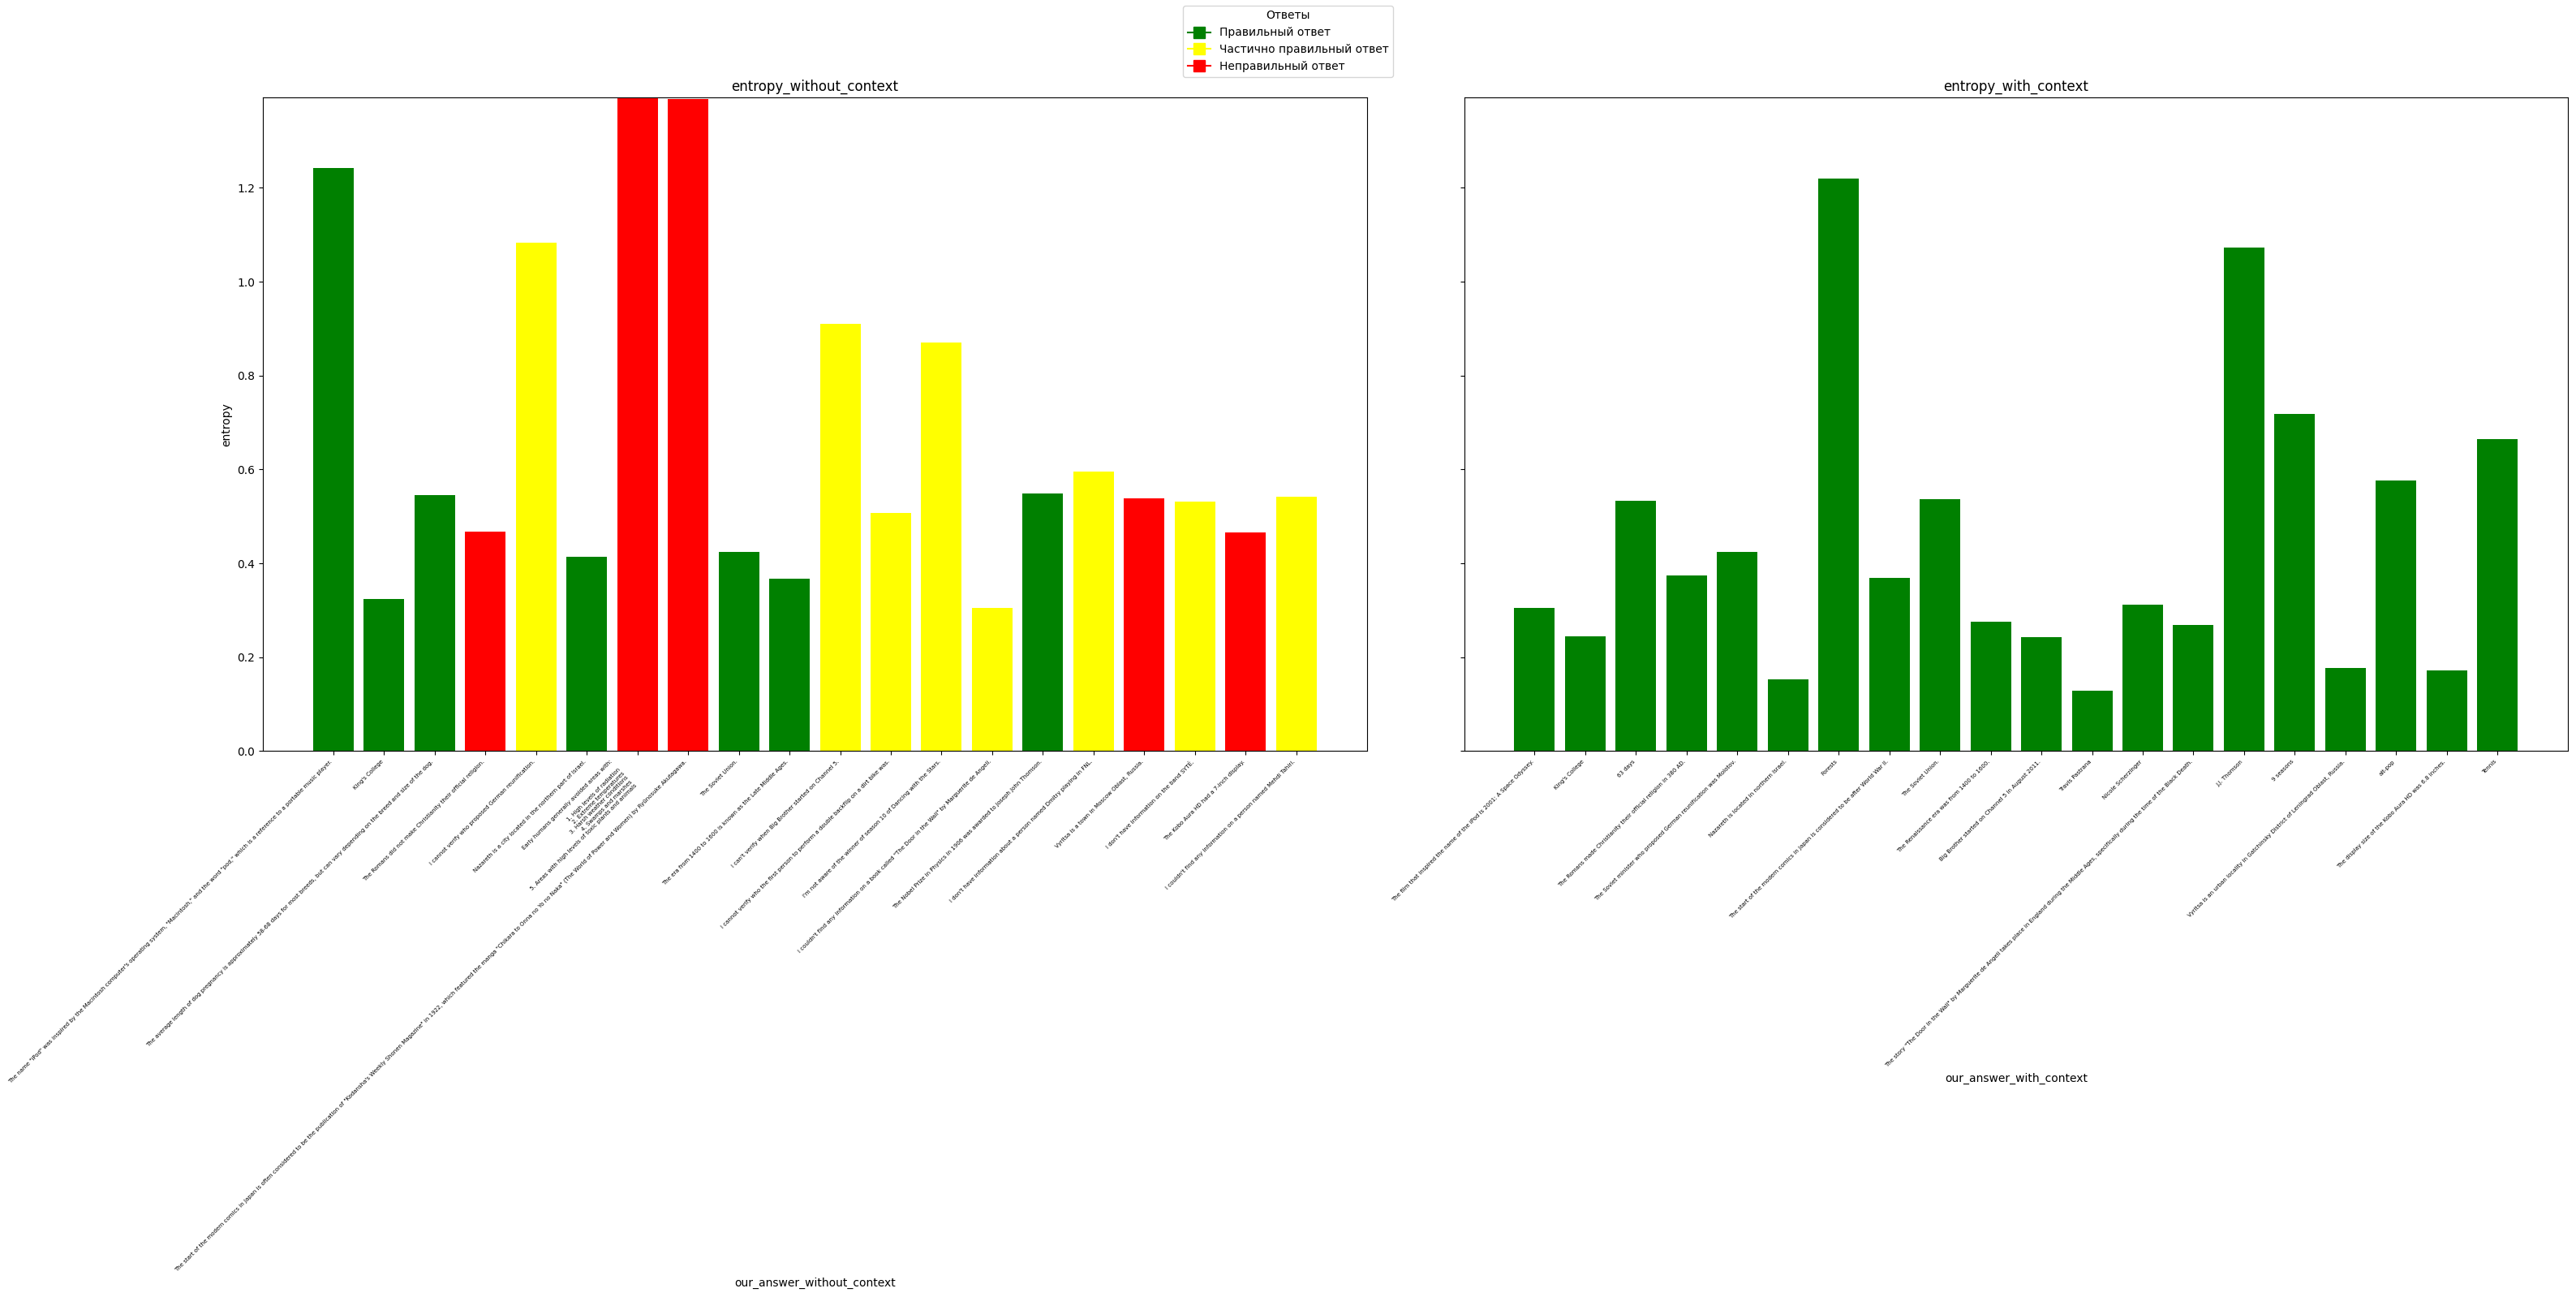

In [11]:
max_y = max(eval_dataset['entropy_without_context'].max(), eval_dataset['entropy_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['entropy_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('entropy')
ax1.set_title('entropy_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['entropy_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('entropy_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

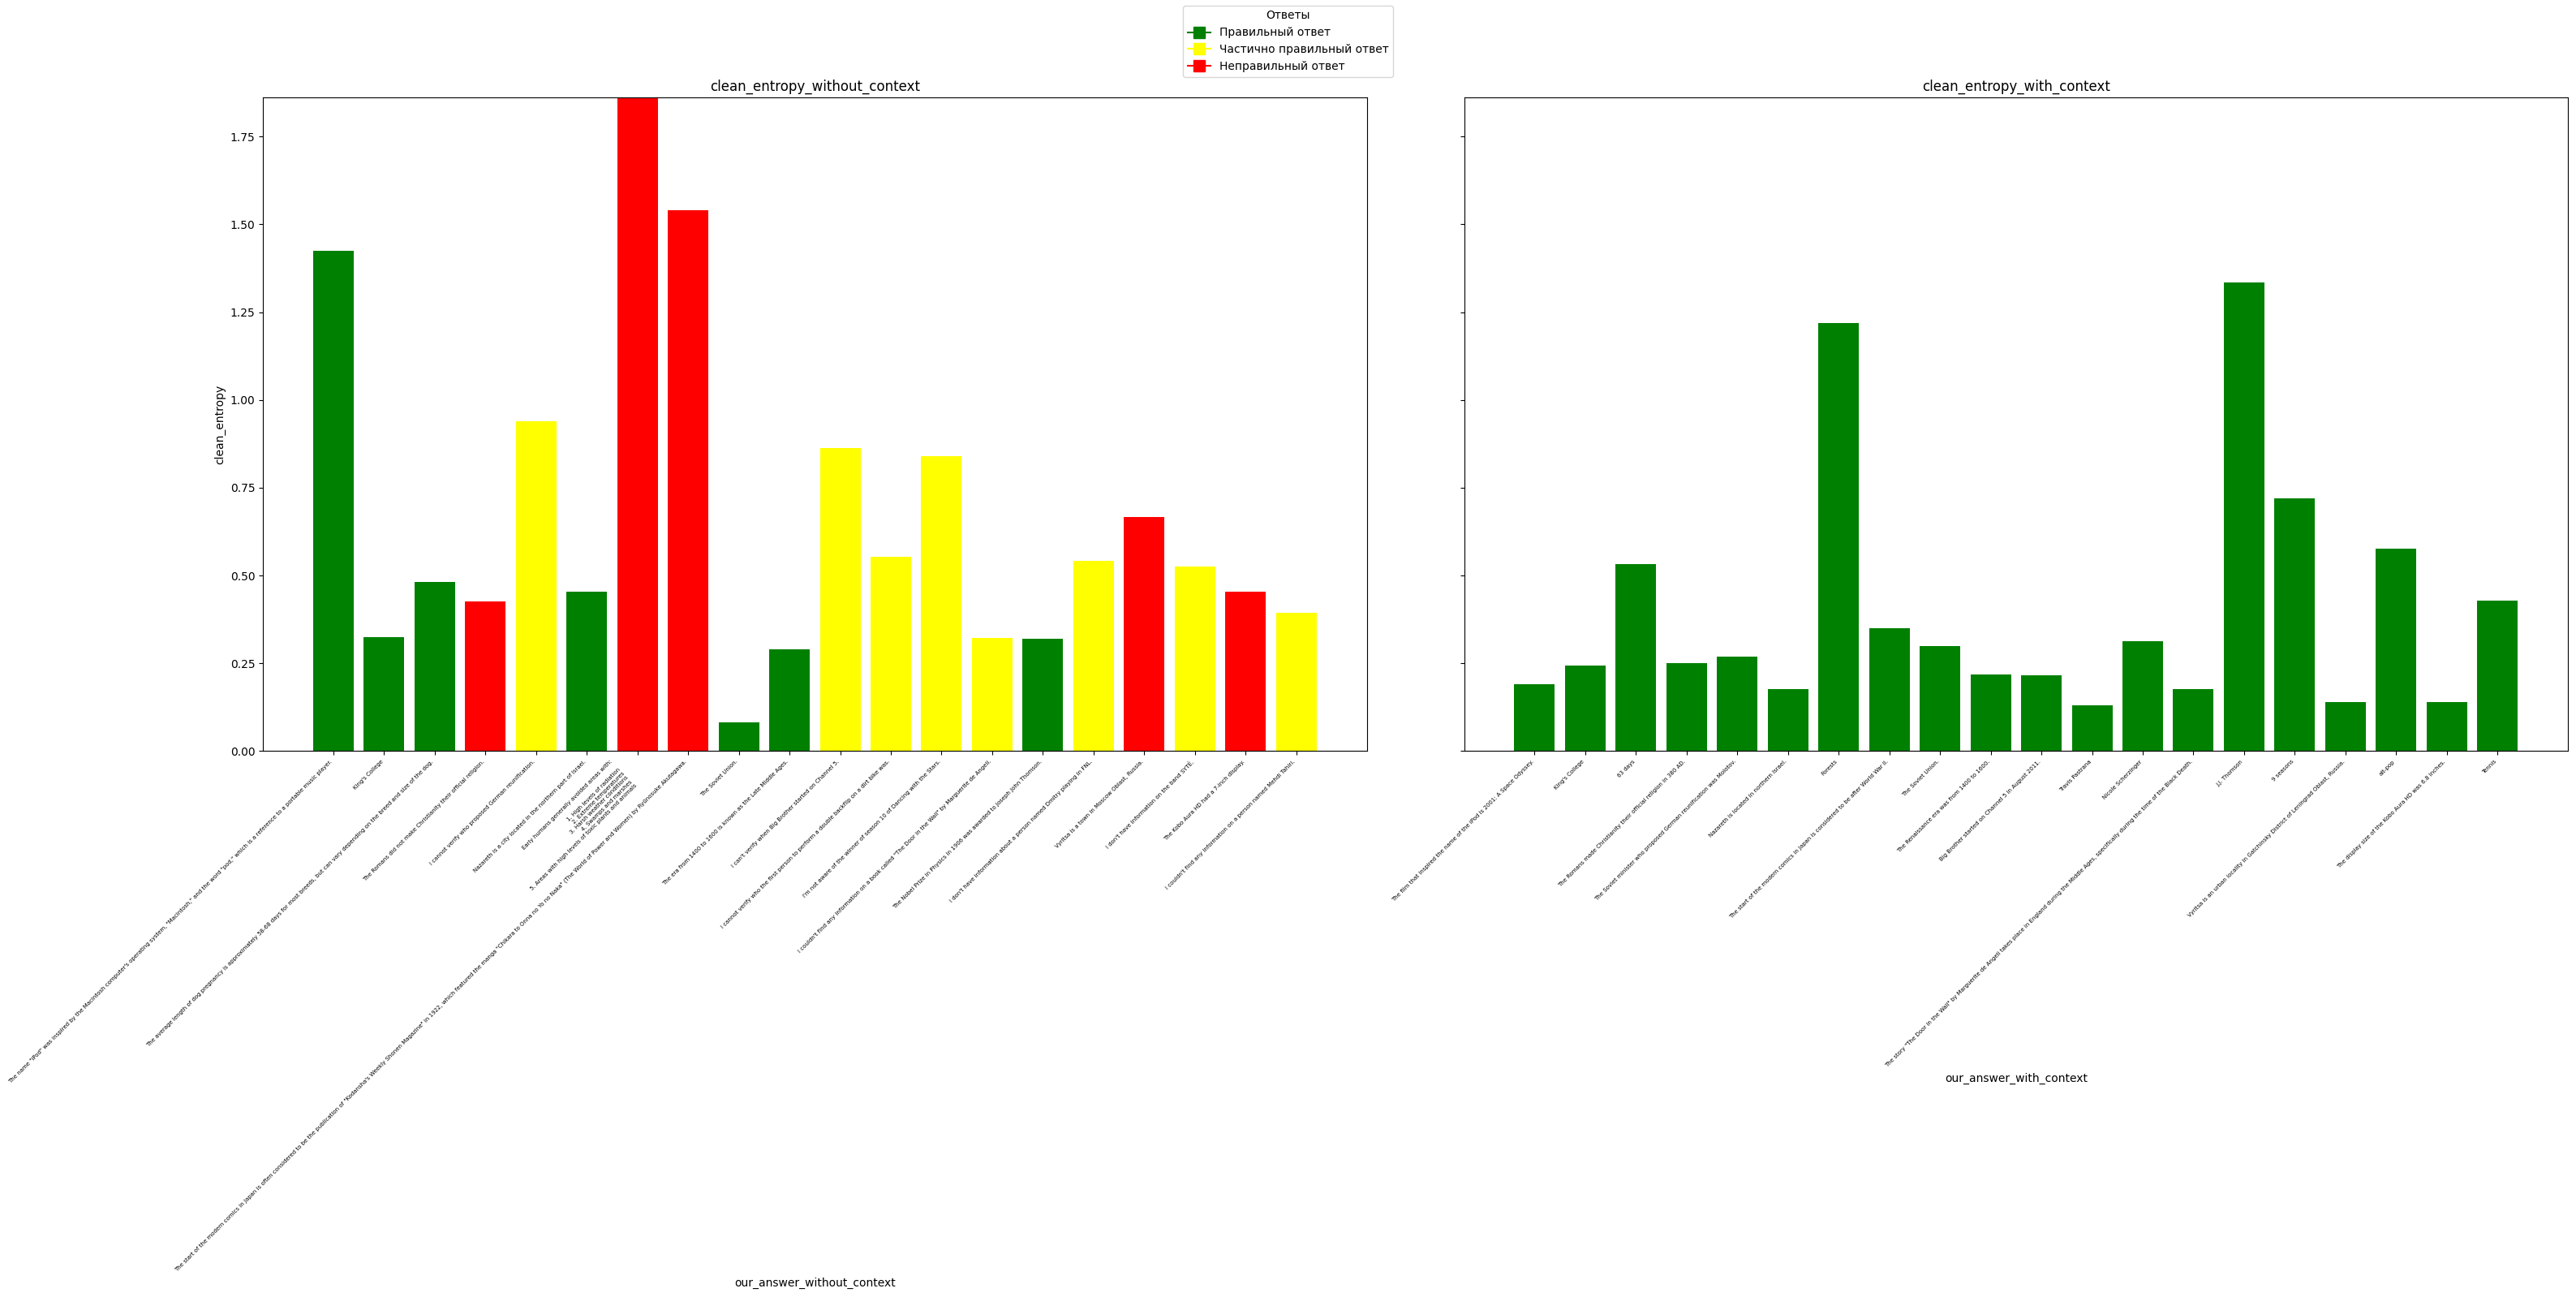

In [13]:
max_y = max(eval_dataset['clean_entropy_without_context'].max(), eval_dataset['clean_entropy_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['clean_entropy_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('clean_entropy')
ax1.set_title('clean_entropy_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['clean_entropy_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('clean_entropy_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

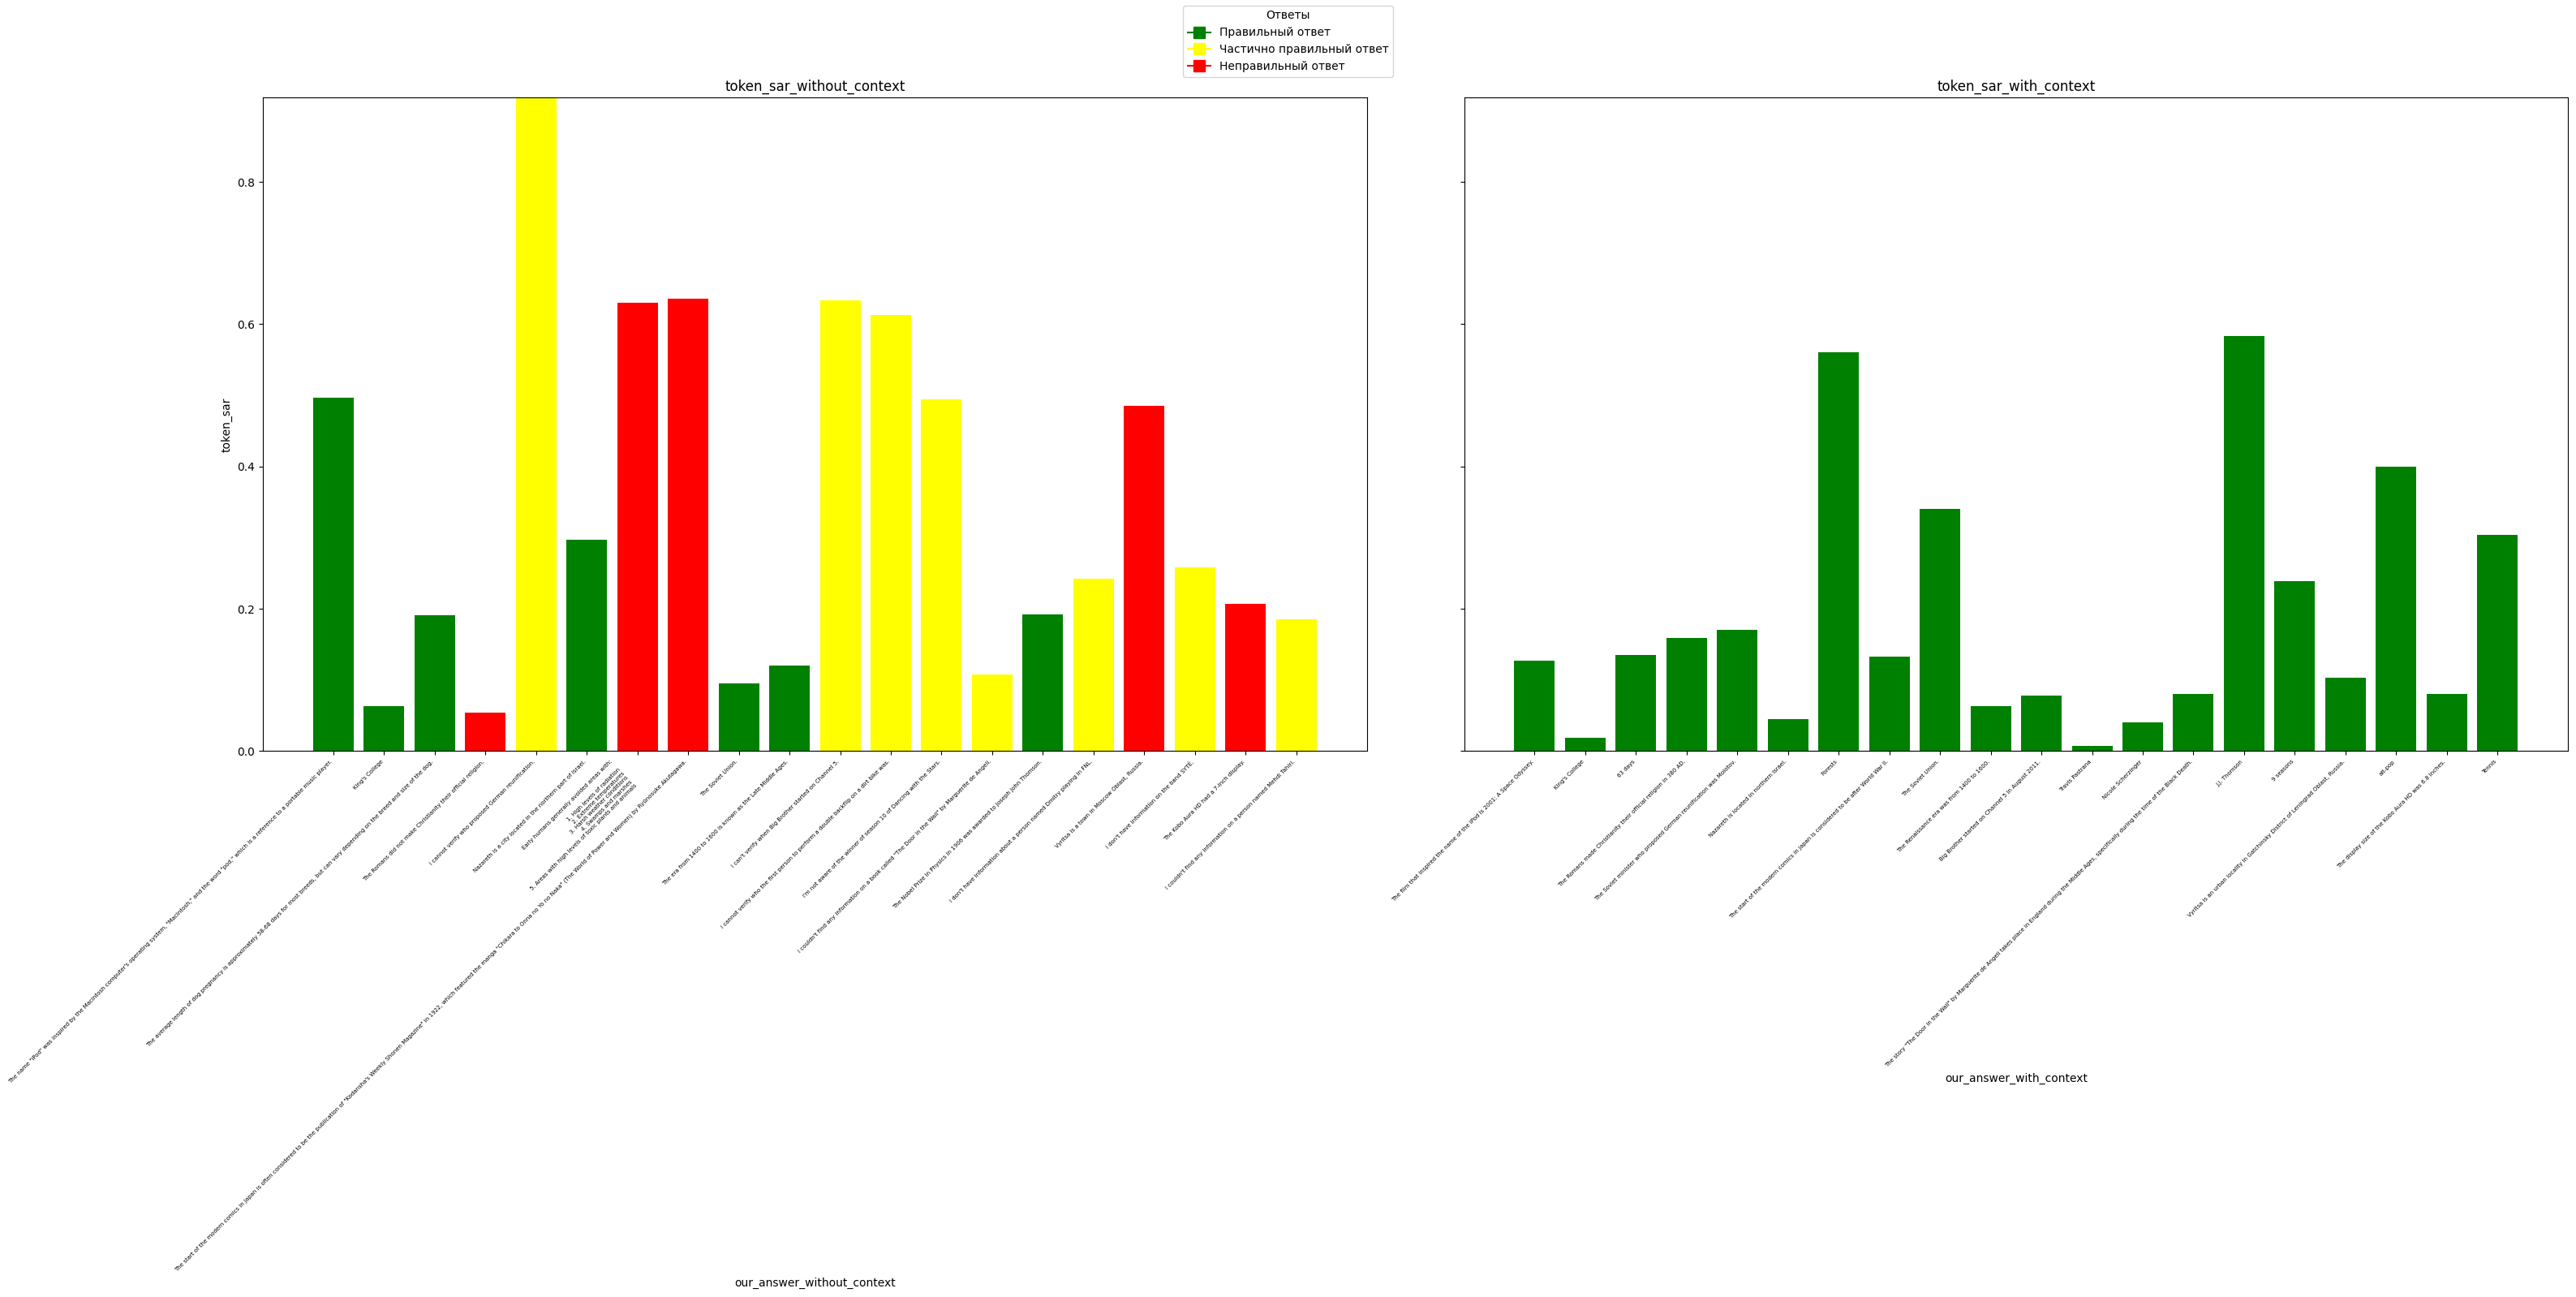

In [15]:
max_y = max(eval_dataset['token_sar_without_context'].max(), eval_dataset['token_sar_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['token_sar_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('token_sar')
ax1.set_title('token_sar_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['token_sar_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('token_sar_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Side by side comparison on our eval ue scores

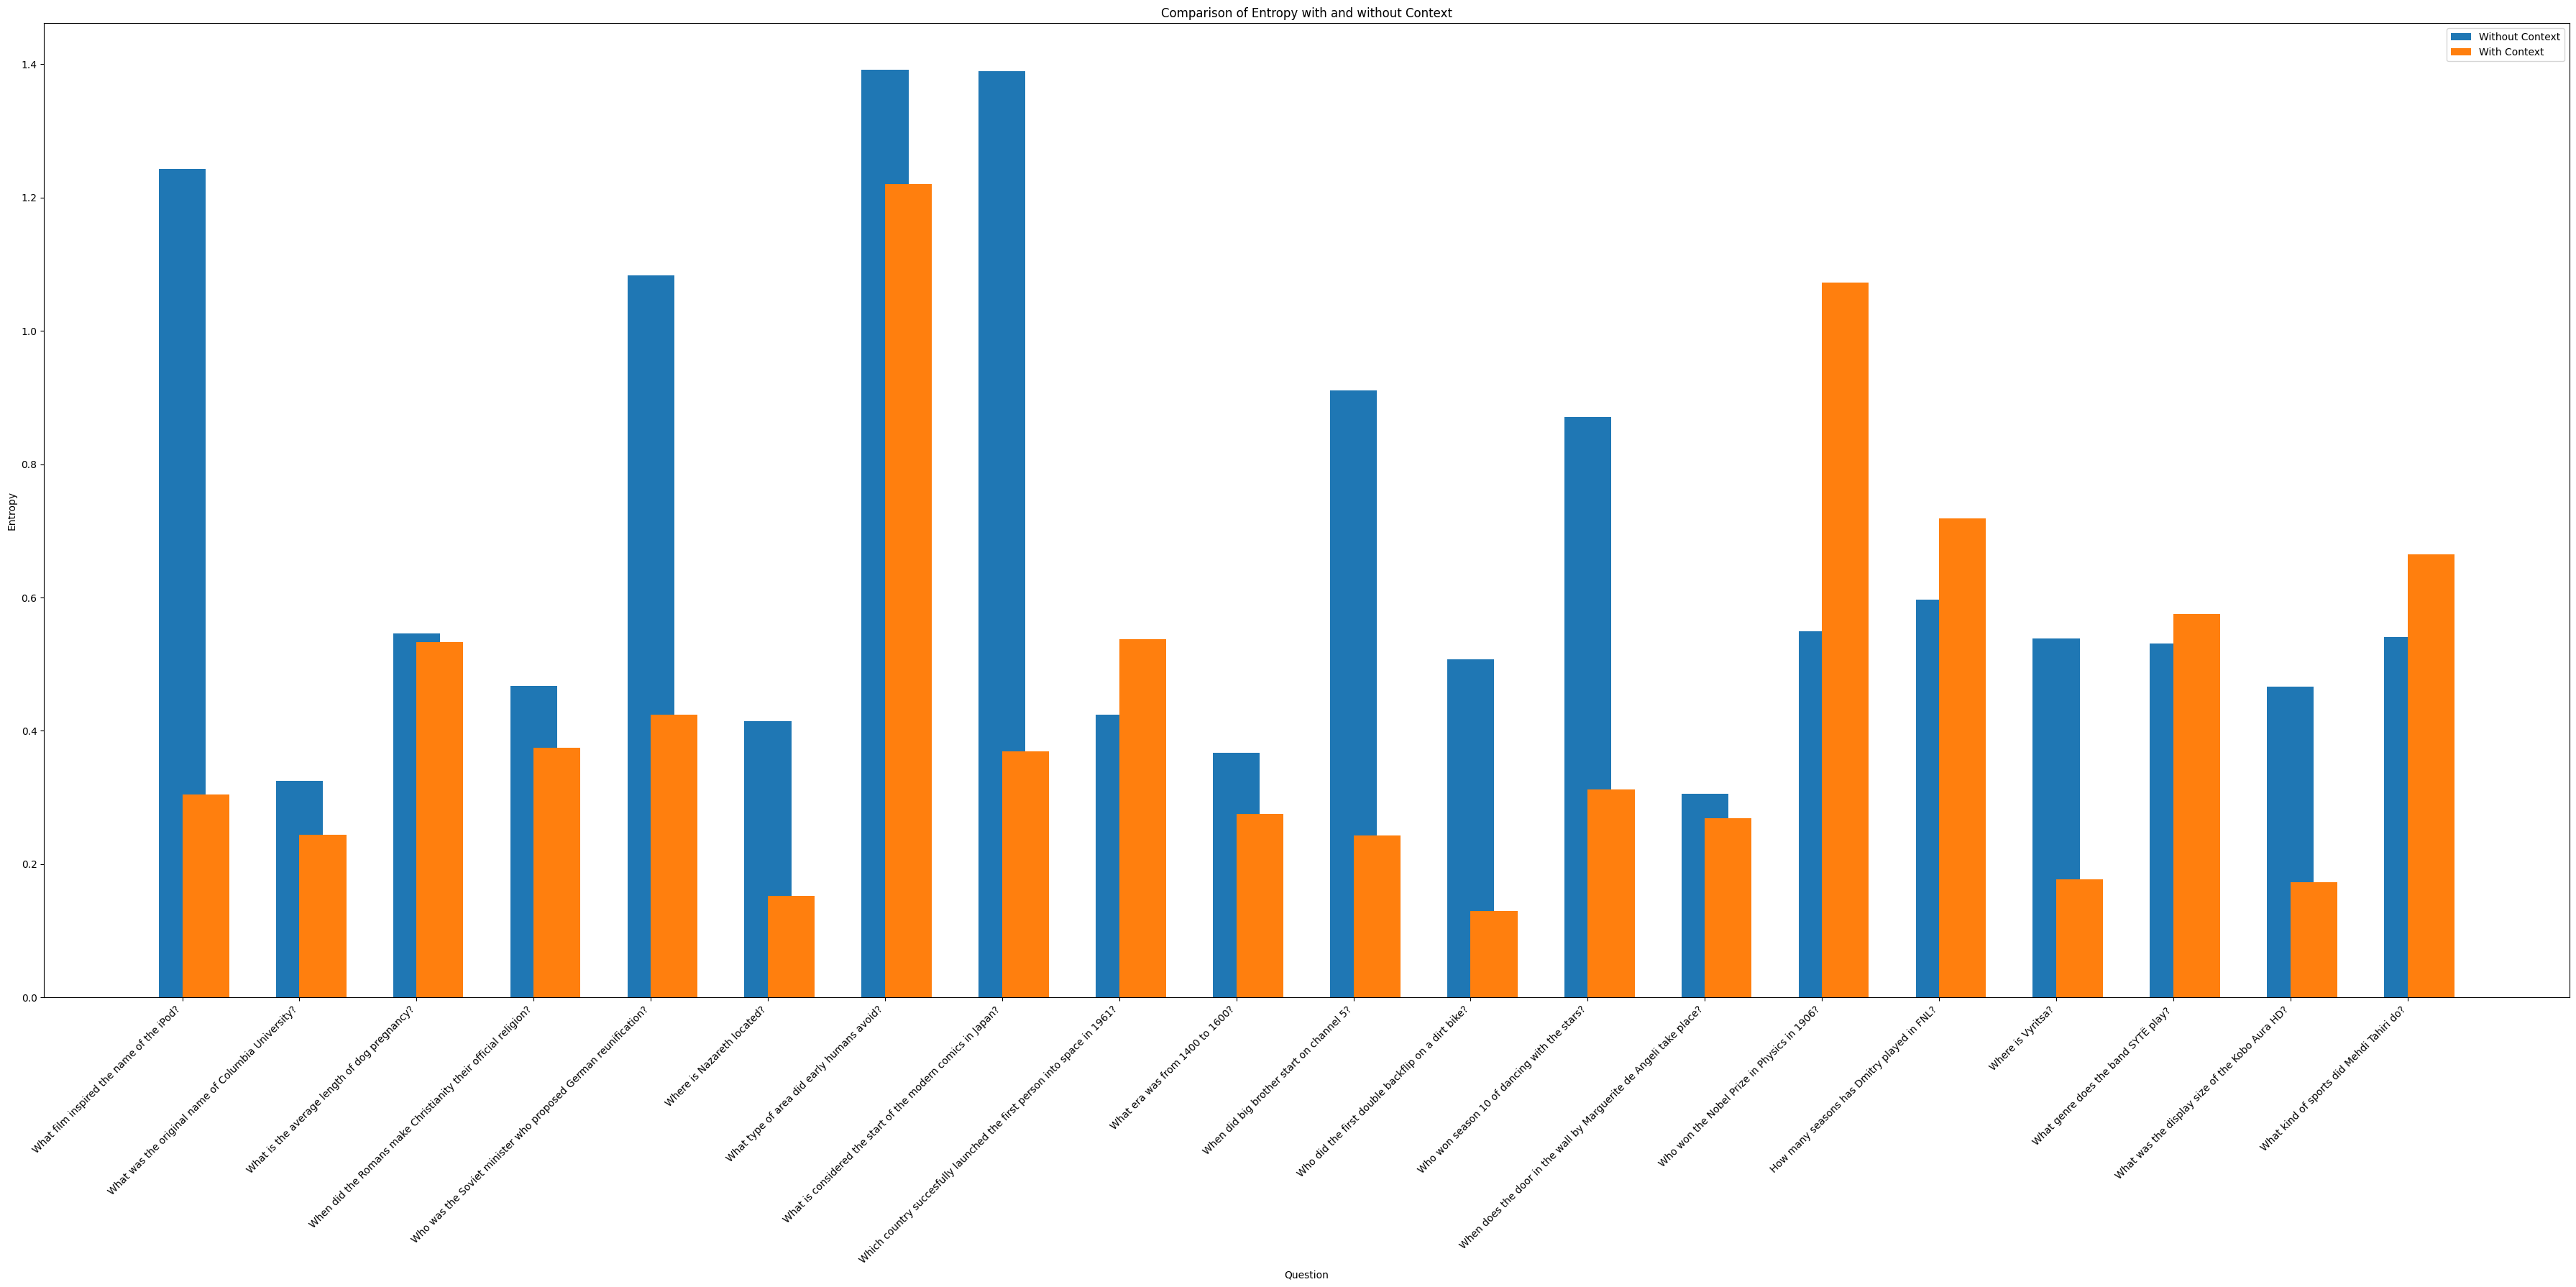

In [16]:
fig, ax = plt.subplots(figsize=(36, 18))

indices = range(len(eval_dataset))

ax.bar(indices, eval_dataset['entropy_without_context'], width=0.4, label='Without Context', align='center')
ax.bar(indices, eval_dataset['entropy_with_context'], width=0.4, label='With Context', align='edge')

ax.set_xlabel("Question")
ax.set_ylabel("Entropy")
ax.set_title("Comparison of Entropy with and without Context")
ax.set_xticks(indices)
ax.set_xticklabels(eval_dataset['question'], rotation=45, ha="right")  
ax.legend()

plt.tight_layout()
plt.show()

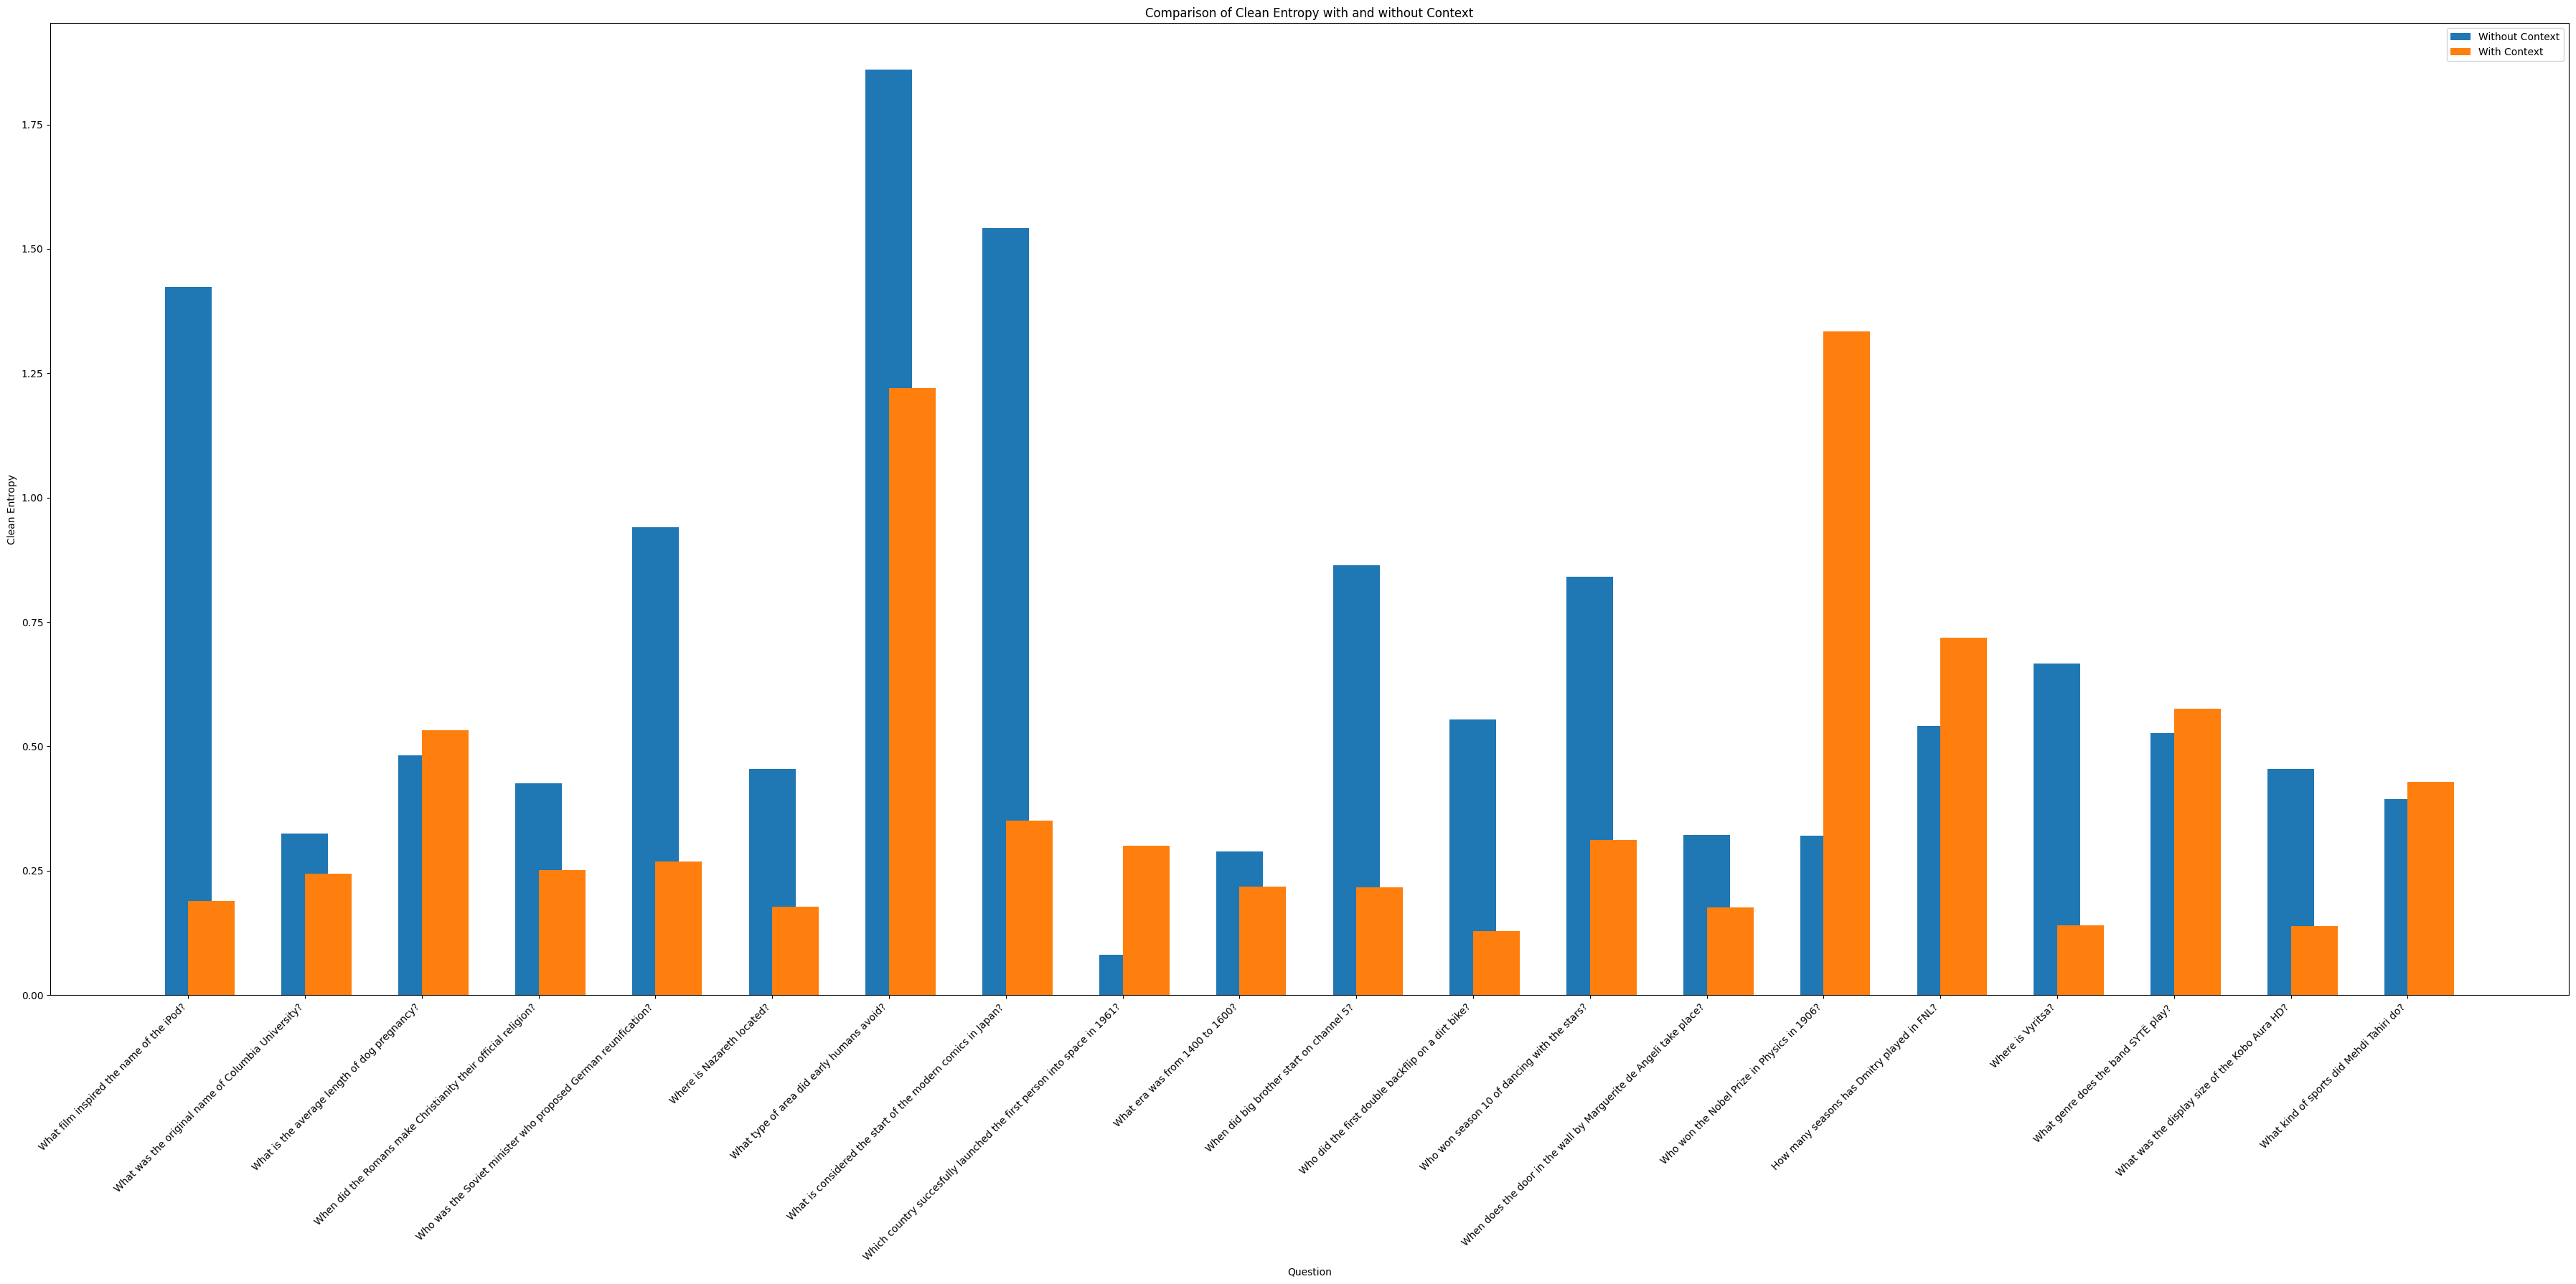

In [17]:
fig, ax = plt.subplots(figsize=(36, 18))

indices = range(len(eval_dataset))

ax.bar(indices, eval_dataset['clean_entropy_without_context'], width=0.4, label='Without Context', align='center')
ax.bar(indices, eval_dataset['clean_entropy_with_context'], width=0.4, label='With Context', align='edge')

ax.set_xlabel("Question")
ax.set_ylabel("Clean Entropy")
ax.set_title("Comparison of Clean Entropy with and without Context")
ax.set_xticks(indices)
ax.set_xticklabels(eval_dataset['question'], rotation=45, ha="right")  
ax.legend()

plt.tight_layout()
plt.show()

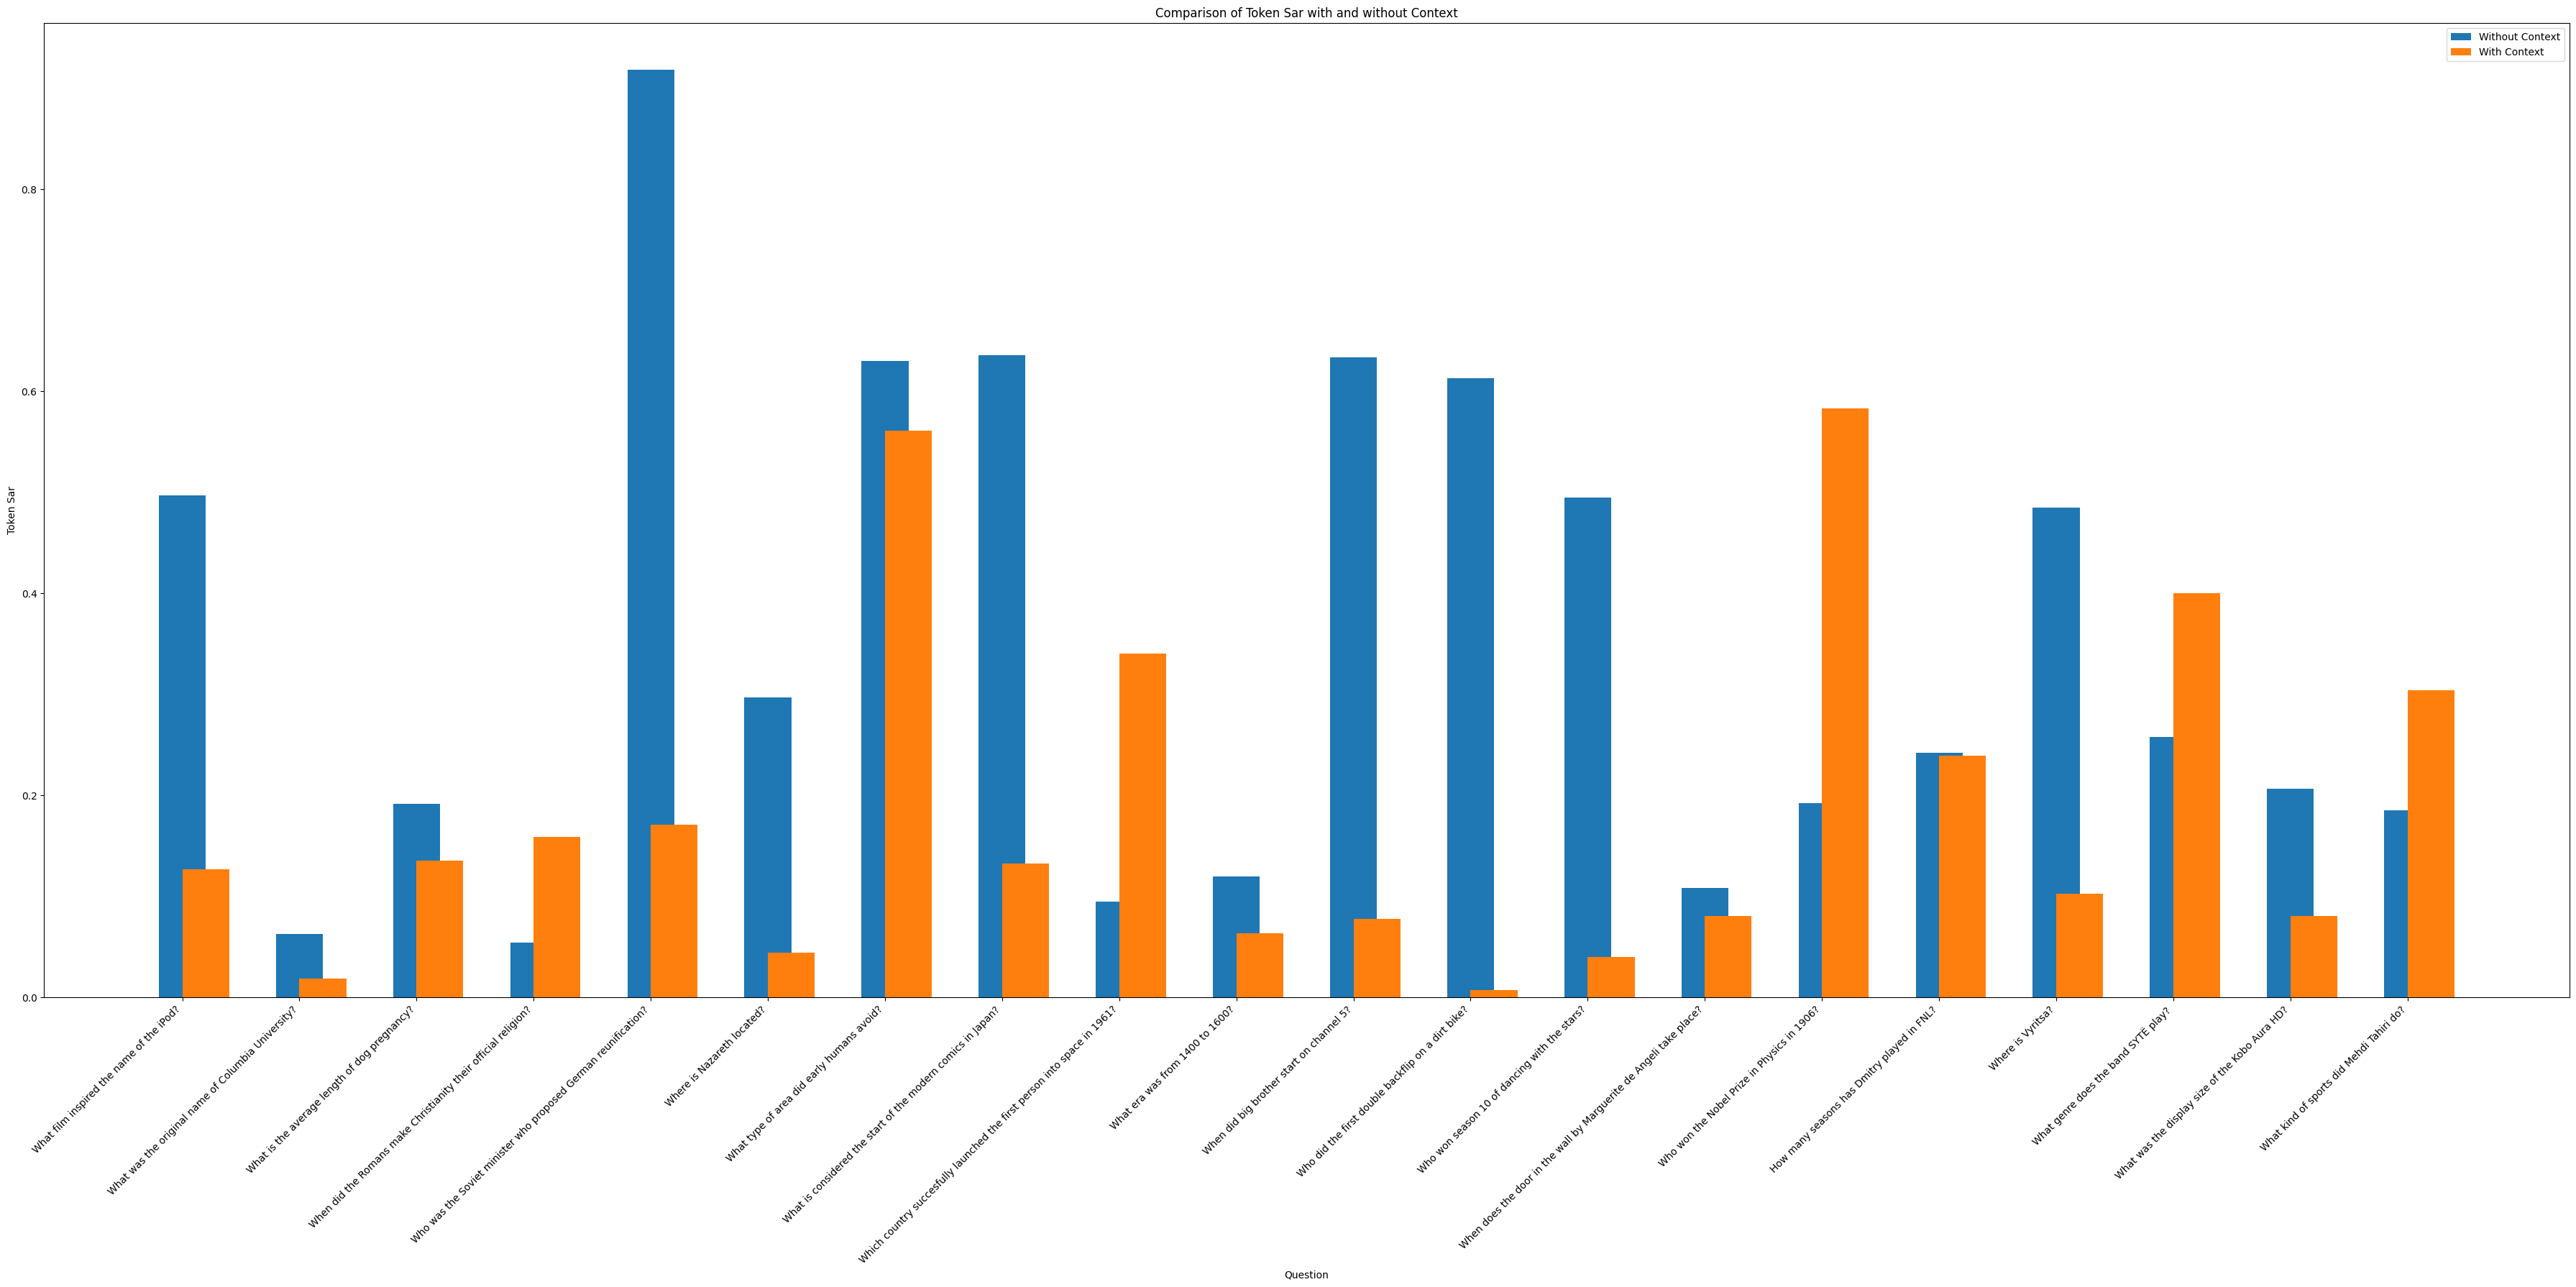

In [18]:
fig, ax = plt.subplots(figsize=(36, 18))

indices = range(len(eval_dataset))

ax.bar(indices, eval_dataset['token_sar_without_context'], width=0.4, label='Without Context', align='center')
ax.bar(indices, eval_dataset['token_sar_with_context'], width=0.4, label='With Context', align='edge')

ax.set_xlabel("Question")
ax.set_ylabel("Token Sar")
ax.set_title("Comparison of Token Sar with and without Context")
ax.set_xticks(indices)
ax.set_xticklabels(eval_dataset['question'], rotation=45, ha="right")  
ax.legend()

plt.tight_layout()
plt.show()

## Context perturbations

In [19]:
eval_dataset = pd.read_csv('data/rag_routing_eval_dataset_context_perturbations.csv')

for index, row in tqdm(eval_dataset.iterrows()):
    question = row['question']
    context = row['context_perturbations']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    # clean_entropy without context
    result = estimate_uncertainty(
        model,
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=True
    )
    answer_without_context, clean_entropy_without_context = result.generation_text, result.uncertainty

    # clean_entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=True
    )
    answer_with_context, clean_entropy_with_context = result.generation_text, result.uncertainty

    # token_sar without context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, token_sar_without_context = result.generation_text, result.uncertainty

    # token_sar with context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, token_sar_with_context = result.generation_text, result.uncertainty

    eval_dataset.loc[index, f'our_answer_without_context'] = answer_without_context
    eval_dataset.loc[index, f'our_answer_with_context'] = answer_with_context

    eval_dataset.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    eval_dataset.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)
    eval_dataset.loc[index, 'clean_entropy_without_context'] = round(clean_entropy_without_context, 4)
    eval_dataset.loc[index, 'clean_entropy_with_context'] = round(clean_entropy_with_context, 4)
    eval_dataset.loc[index, 'token_sar_without_context'] = round(token_sar_without_context, 4)
    eval_dataset.loc[index, 'token_sar_with_context'] = round(token_sar_with_context, 4)

7it [04:46, 40.91s/it]


In [20]:
eval_dataset['is_correct_without_context'] = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
eval_dataset['is_correct_with_context'] = [1, 0, 0, 0.5, 0, 0.5, 1]

In [21]:
color_map = {1: 'green', 0.5: 'yellow', 0: 'red'}
colors_with_context = eval_dataset['is_correct_with_context'].map(color_map)
colors_without_context = eval_dataset['is_correct_without_context'].map(color_map)

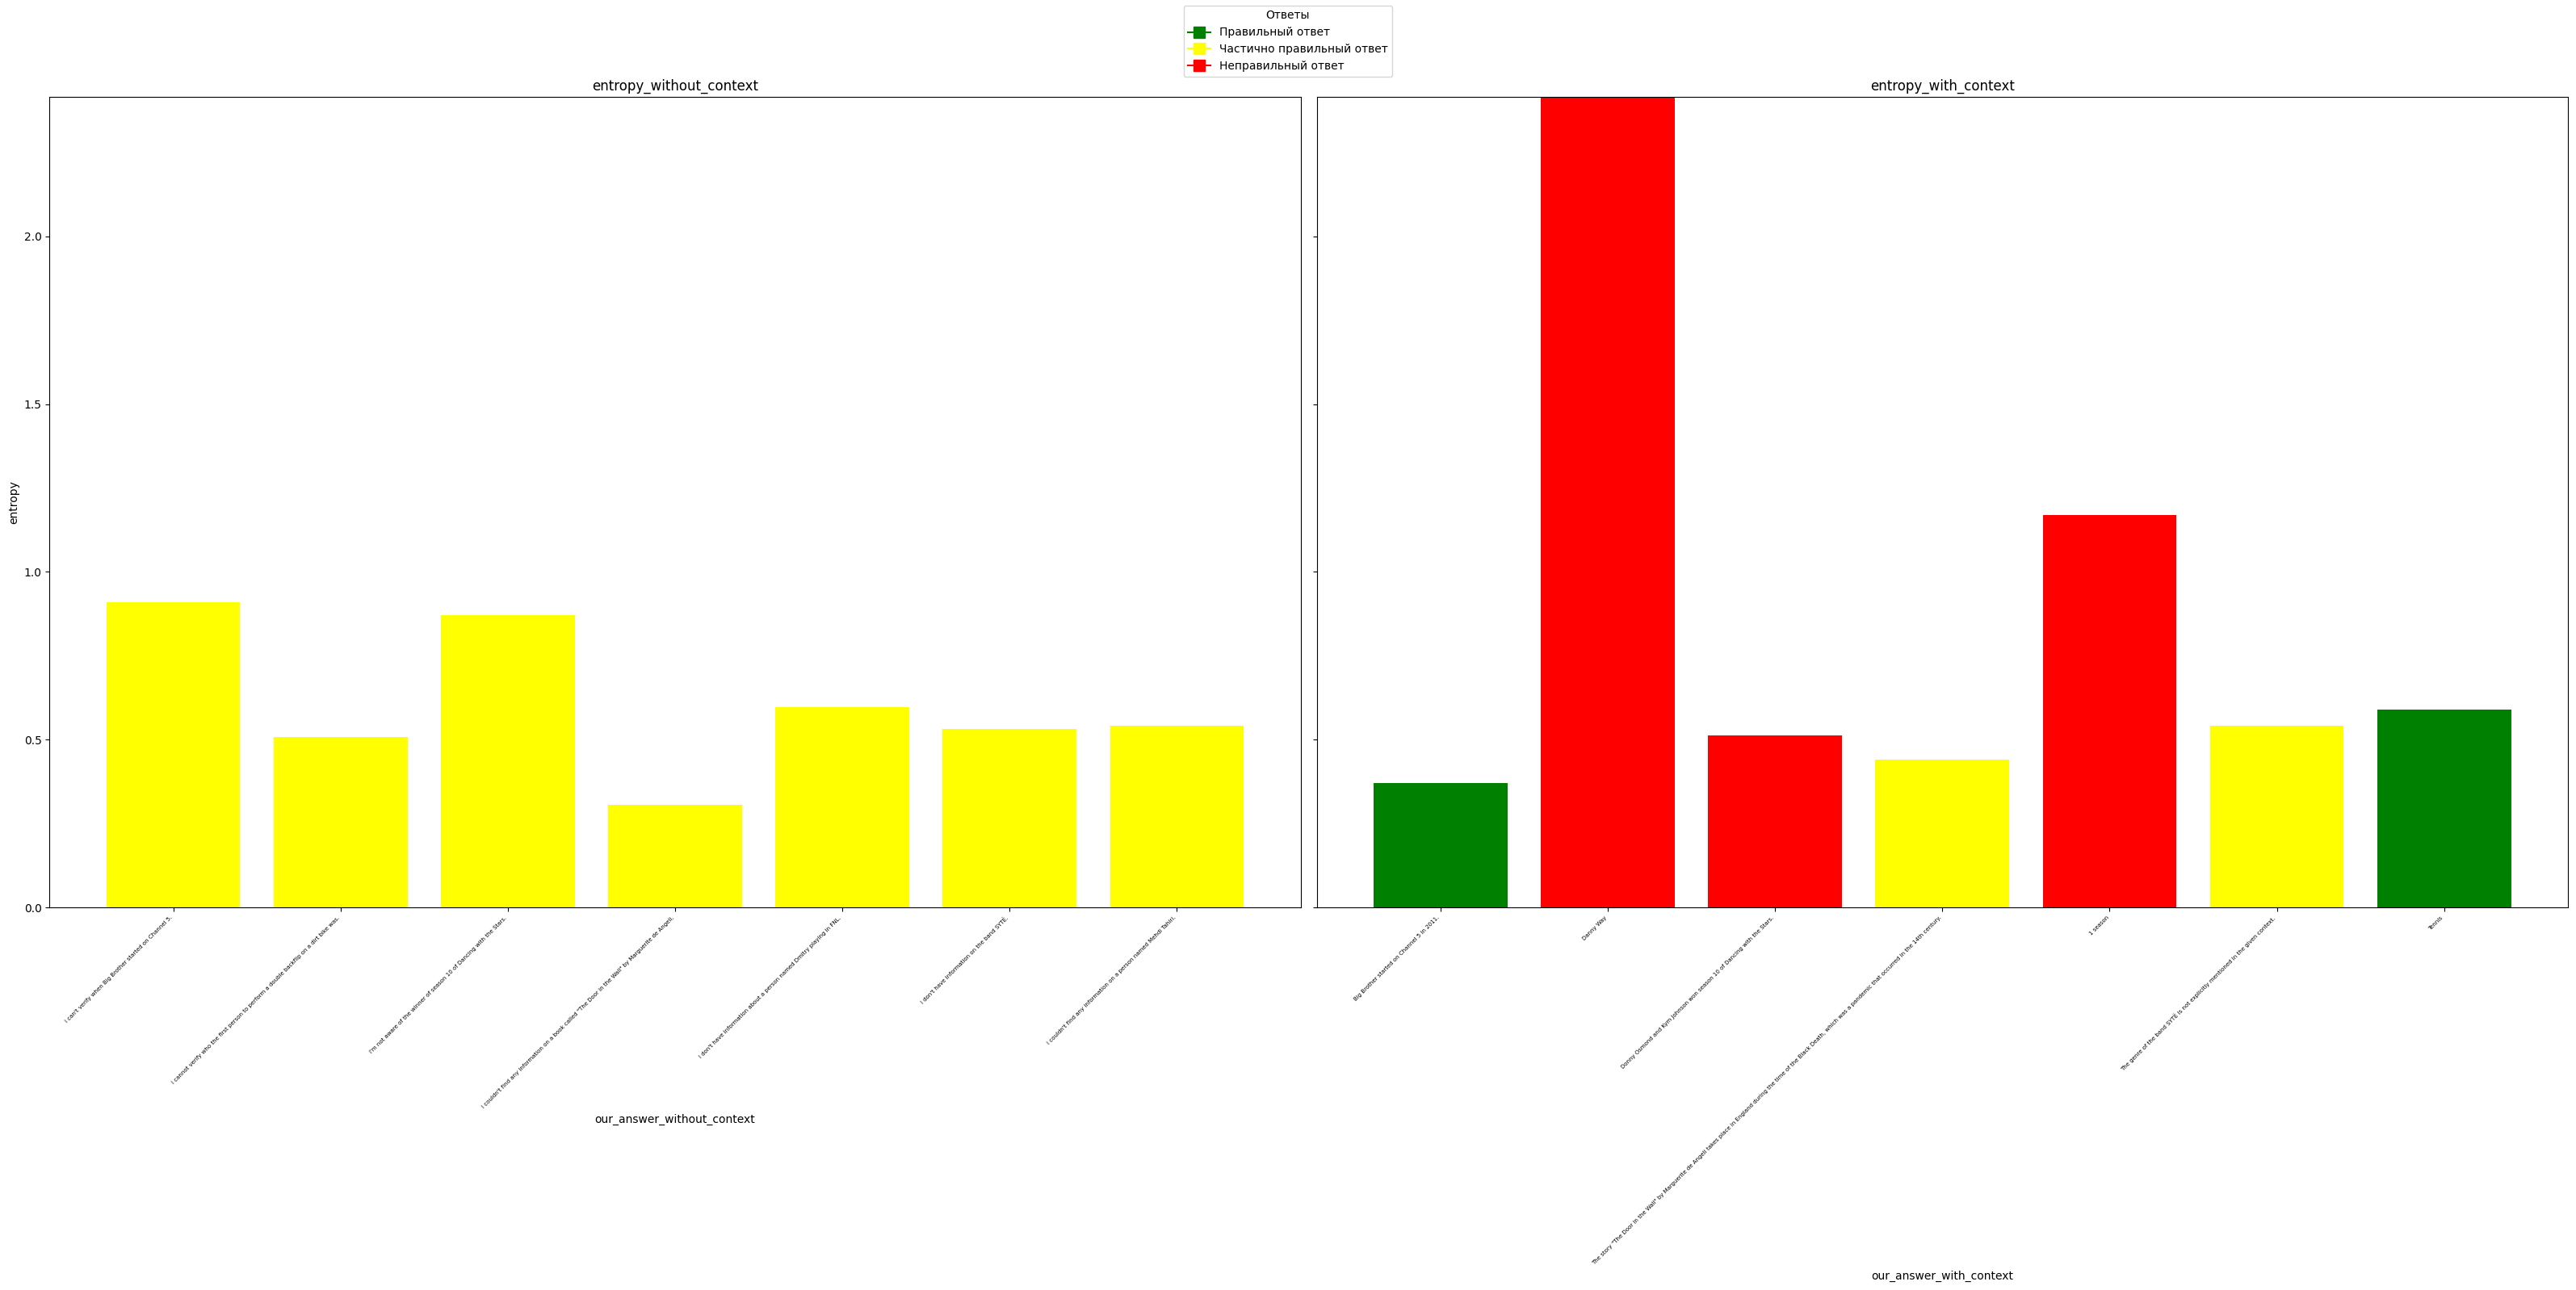

In [22]:
max_y = max(eval_dataset['entropy_without_context'].max(), eval_dataset['entropy_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['entropy_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('entropy')
ax1.set_title('entropy_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['entropy_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('entropy_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

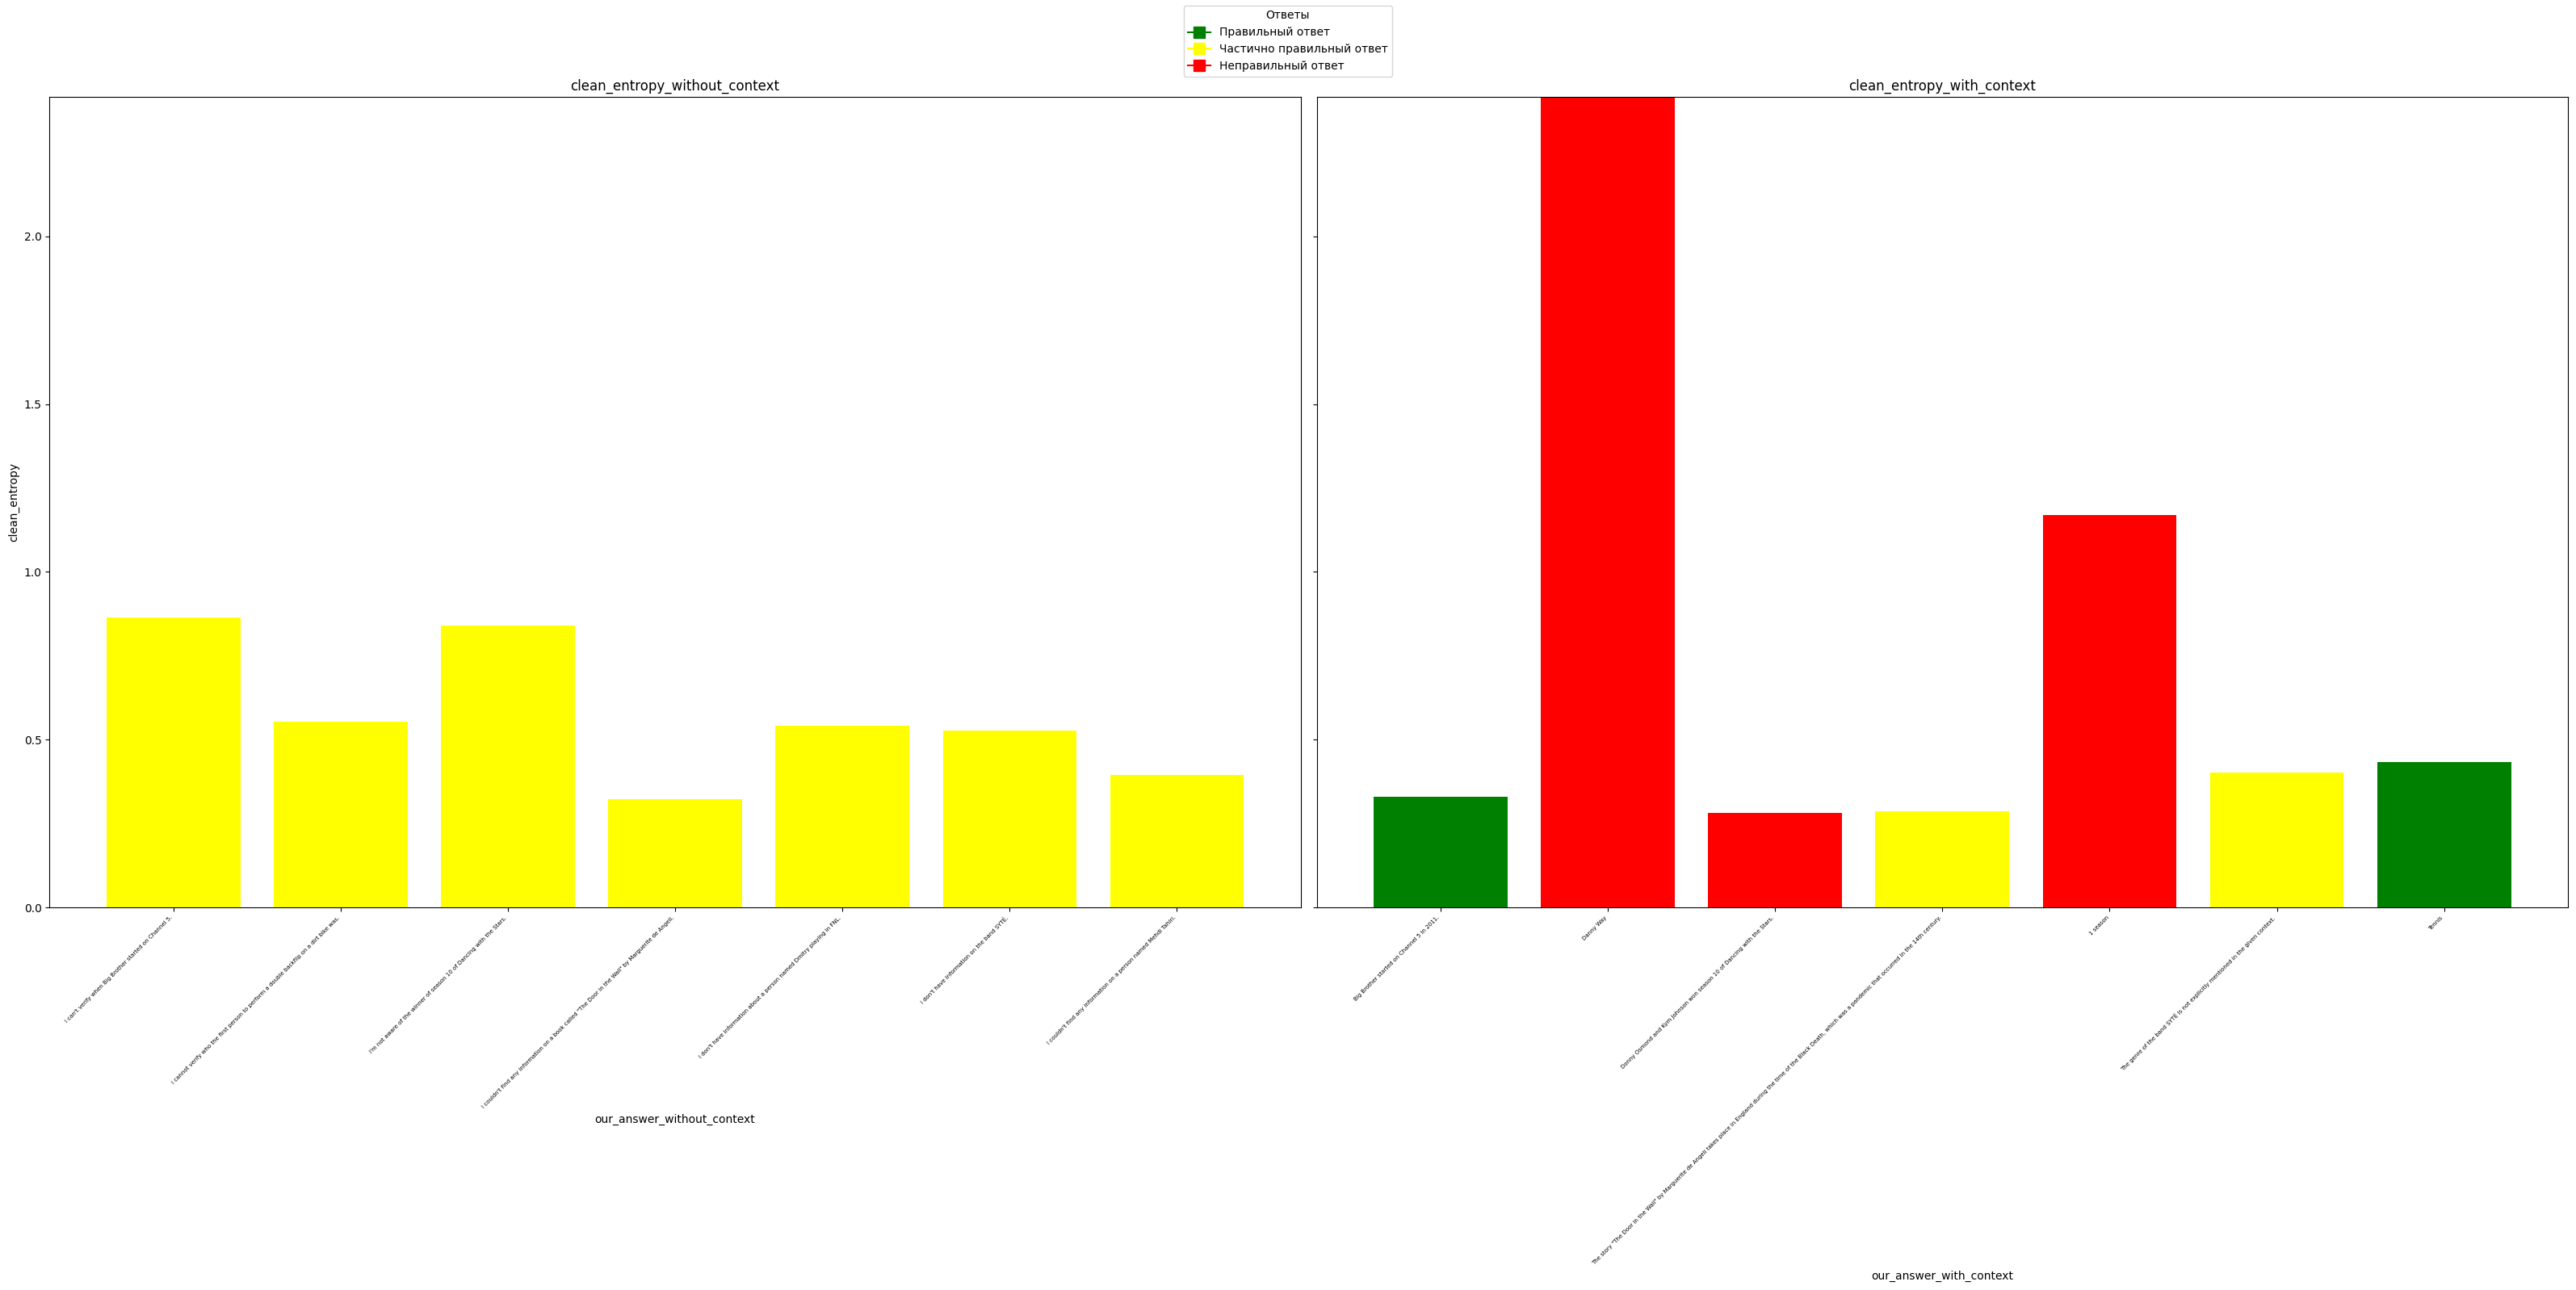

In [23]:
max_y = max(eval_dataset['clean_entropy_without_context'].max(), eval_dataset['clean_entropy_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['clean_entropy_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('clean_entropy')
ax1.set_title('clean_entropy_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['clean_entropy_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('clean_entropy_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

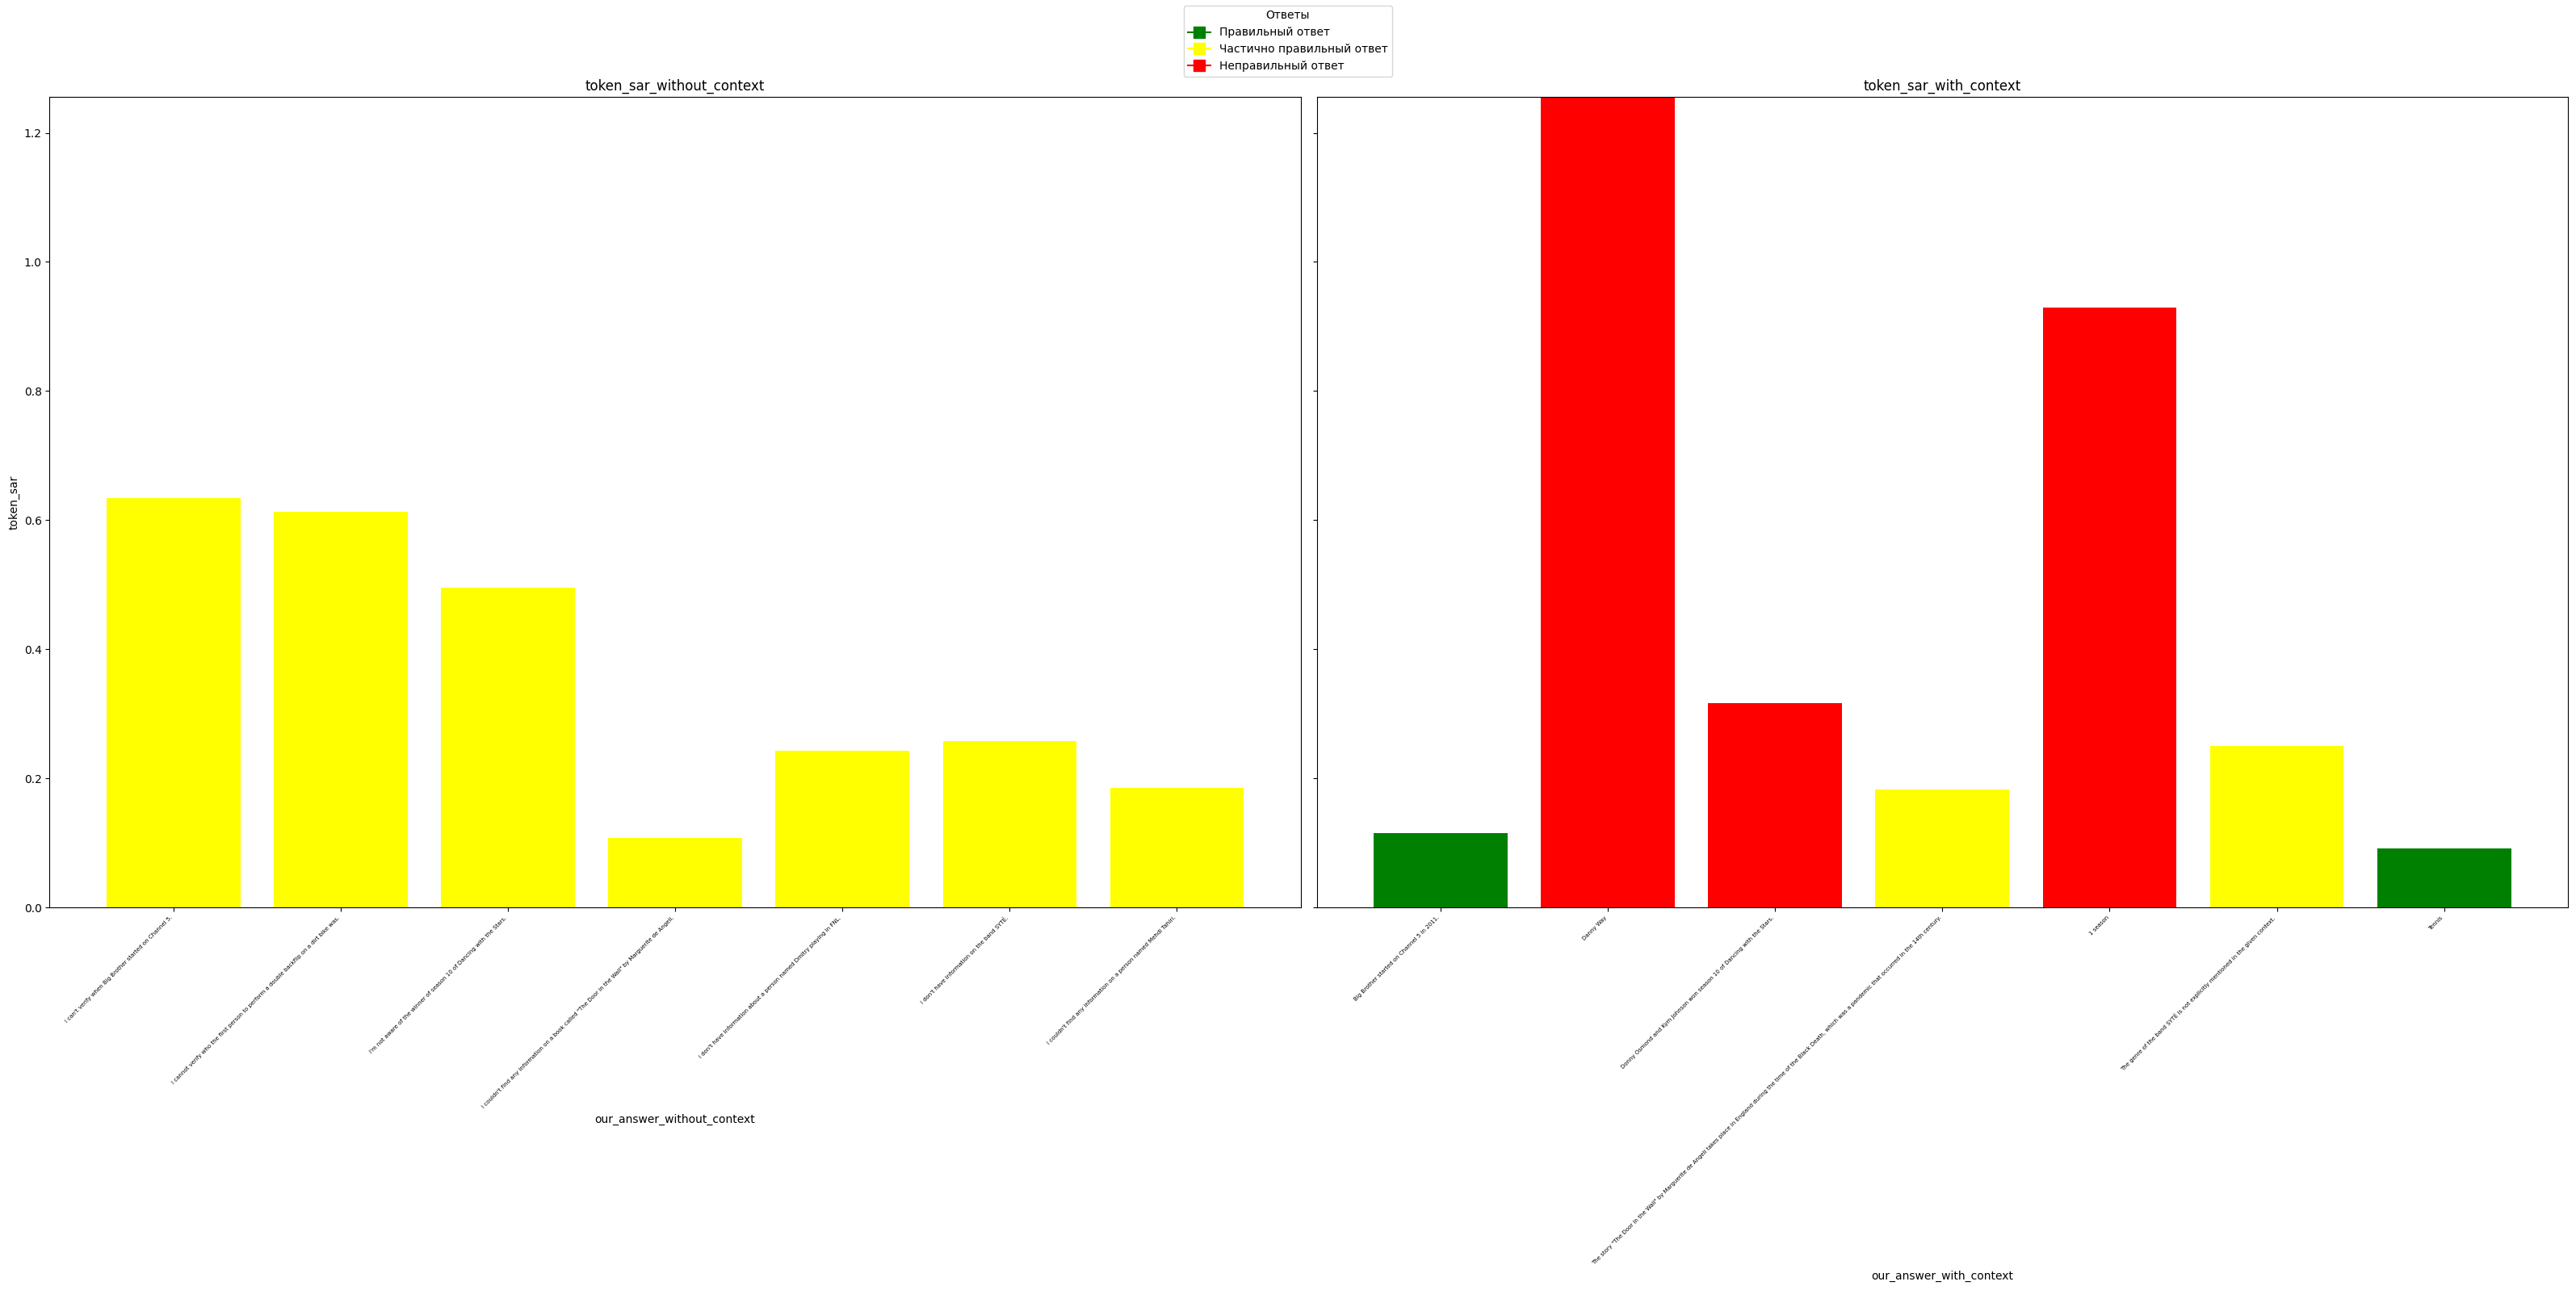

In [24]:
max_y = max(eval_dataset['token_sar_without_context'].max(), eval_dataset['token_sar_with_context'].max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

bars1 = ax1.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['token_sar_without_context'], 
    color=colors_without_context
)
ax1.set_ylim(0, max_y) 
ax1.set_xticklabels(eval_dataset['our_answer_without_context'], rotation=45, ha='right', fontsize=5)
ax1.set_xlabel('our_answer_without_context')
ax1.set_ylabel('token_sar')
ax1.set_title('token_sar_without_context')

bars2 = ax2.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['token_sar_with_context'], 
    color=colors_with_context
)
ax2.set_ylim(0, max_y)
ax2.set_xticklabels(eval_dataset['our_answer_with_context'], rotation=45, ha='right', fontsize=5)
ax2.set_xlabel('our_answer_with_context')
ax2.set_title('token_sar_with_context')

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Side by side comparison on our eval ue scores

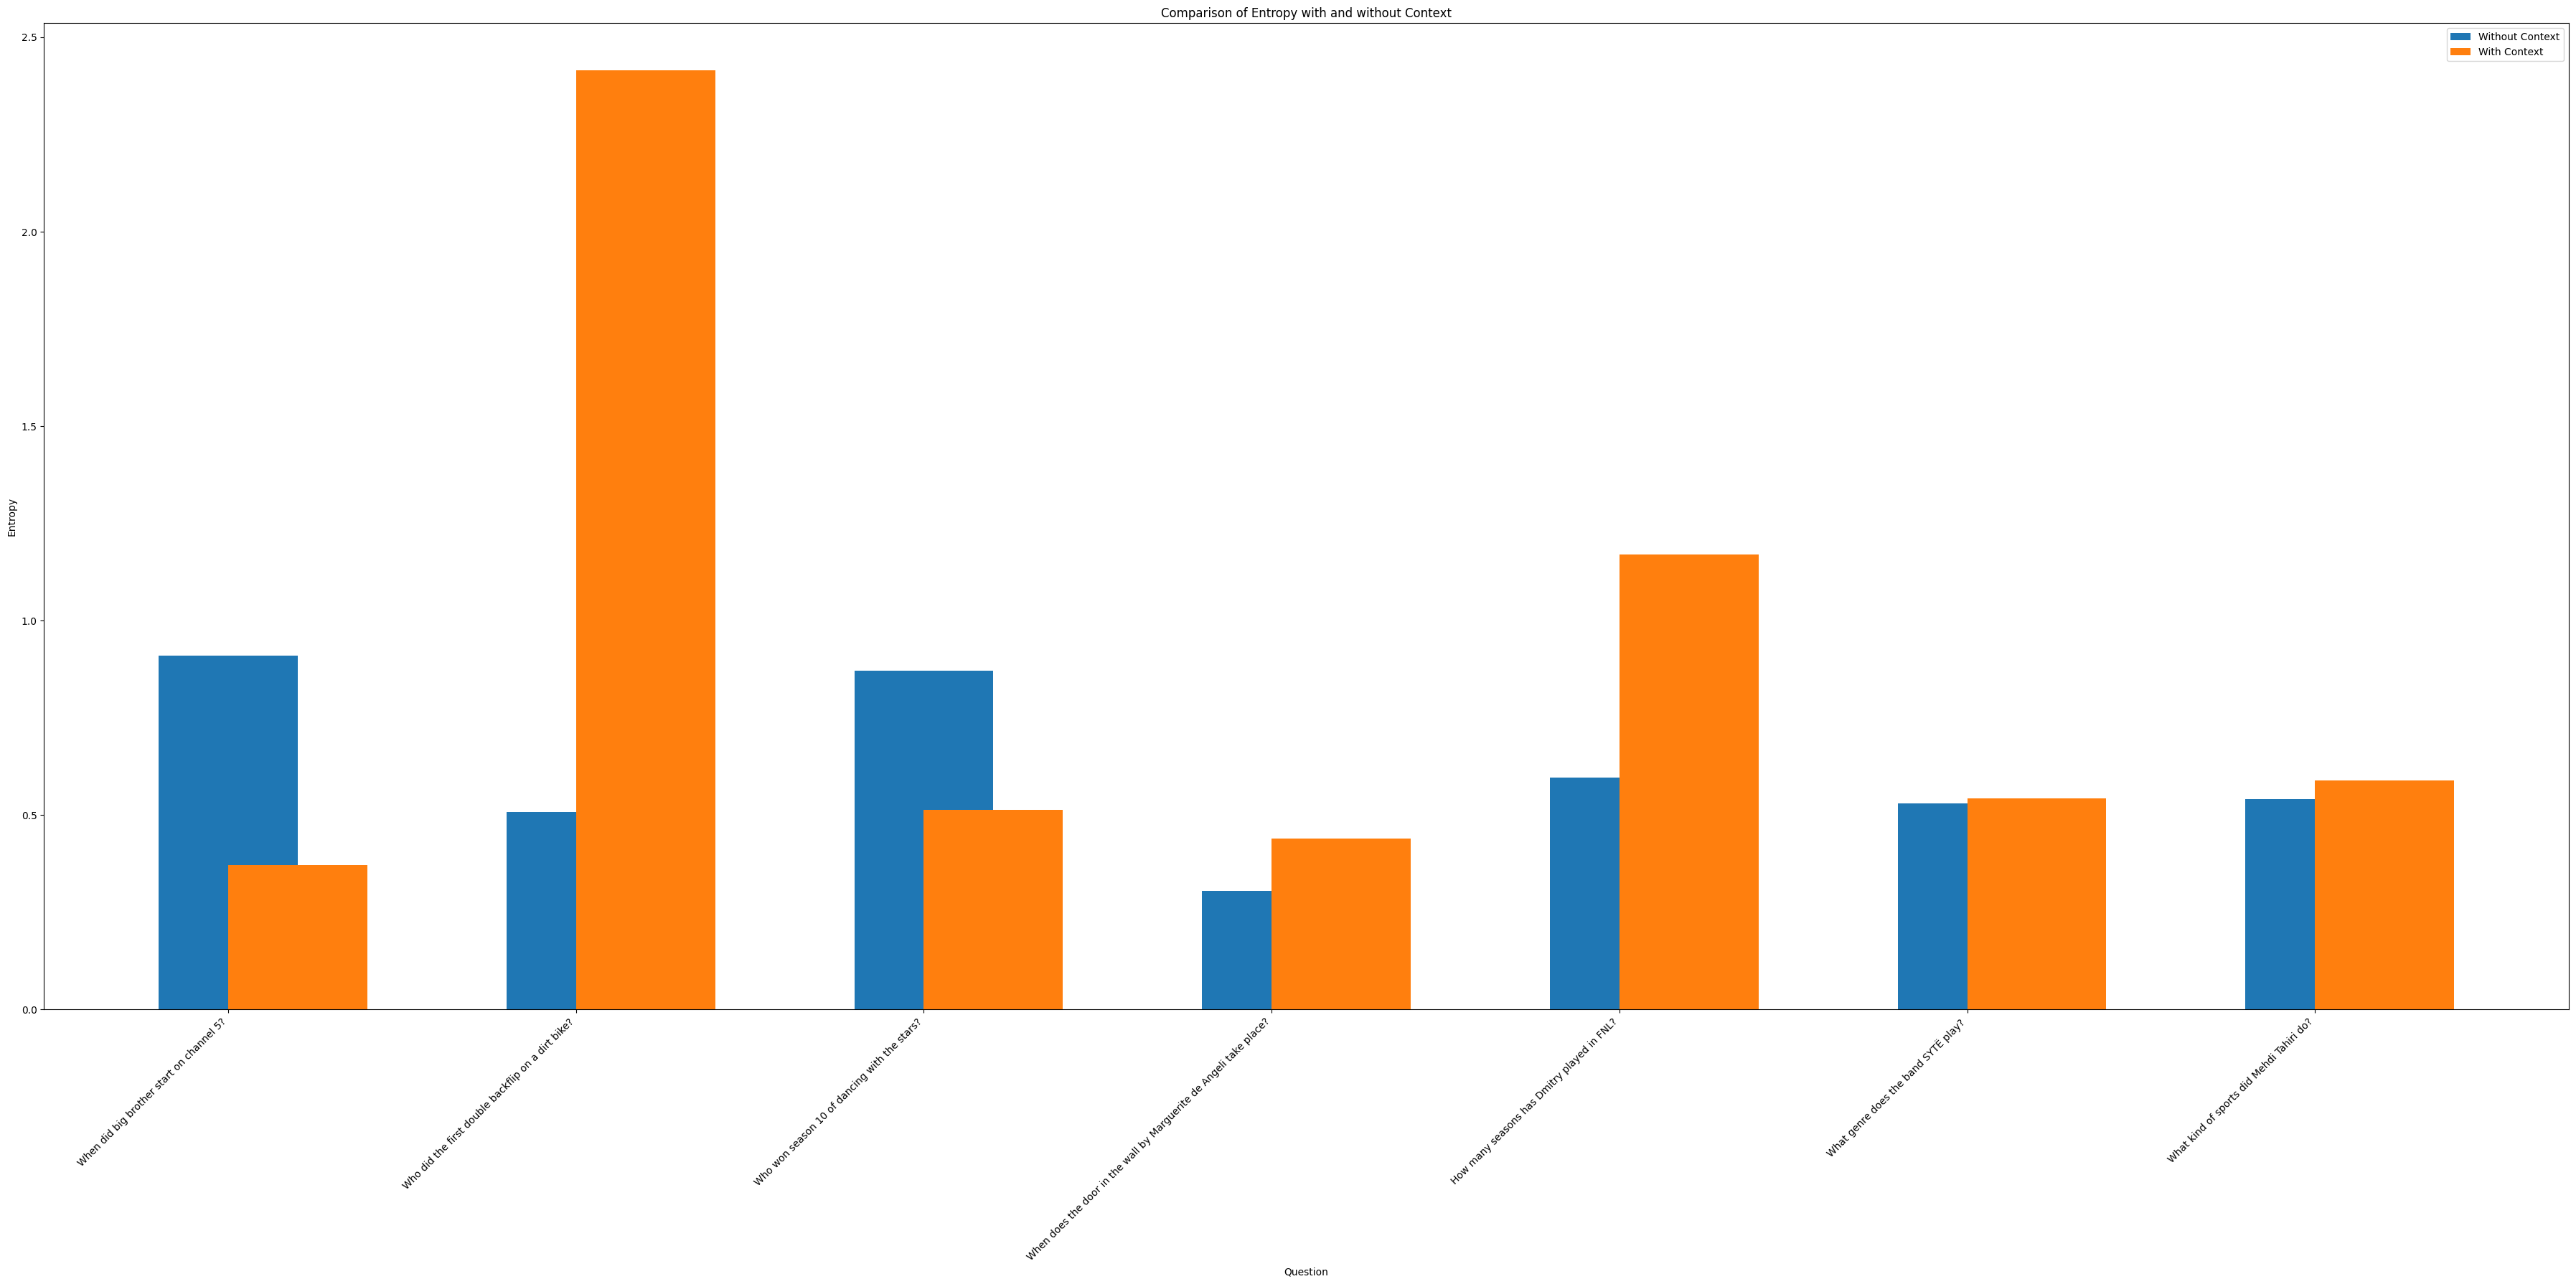

In [25]:
fig, ax = plt.subplots(figsize=(36, 18))

indices = range(len(eval_dataset))

ax.bar(indices, eval_dataset['entropy_without_context'], width=0.4, label='Without Context', align='center')
ax.bar(indices, eval_dataset['entropy_with_context'], width=0.4, label='With Context', align='edge')

ax.set_xlabel("Question")
ax.set_ylabel("Entropy")
ax.set_title("Comparison of Entropy with and without Context")
ax.set_xticks(indices)
ax.set_xticklabels(eval_dataset['question'], rotation=45, ha="right")  
ax.legend()

plt.tight_layout()
plt.show()

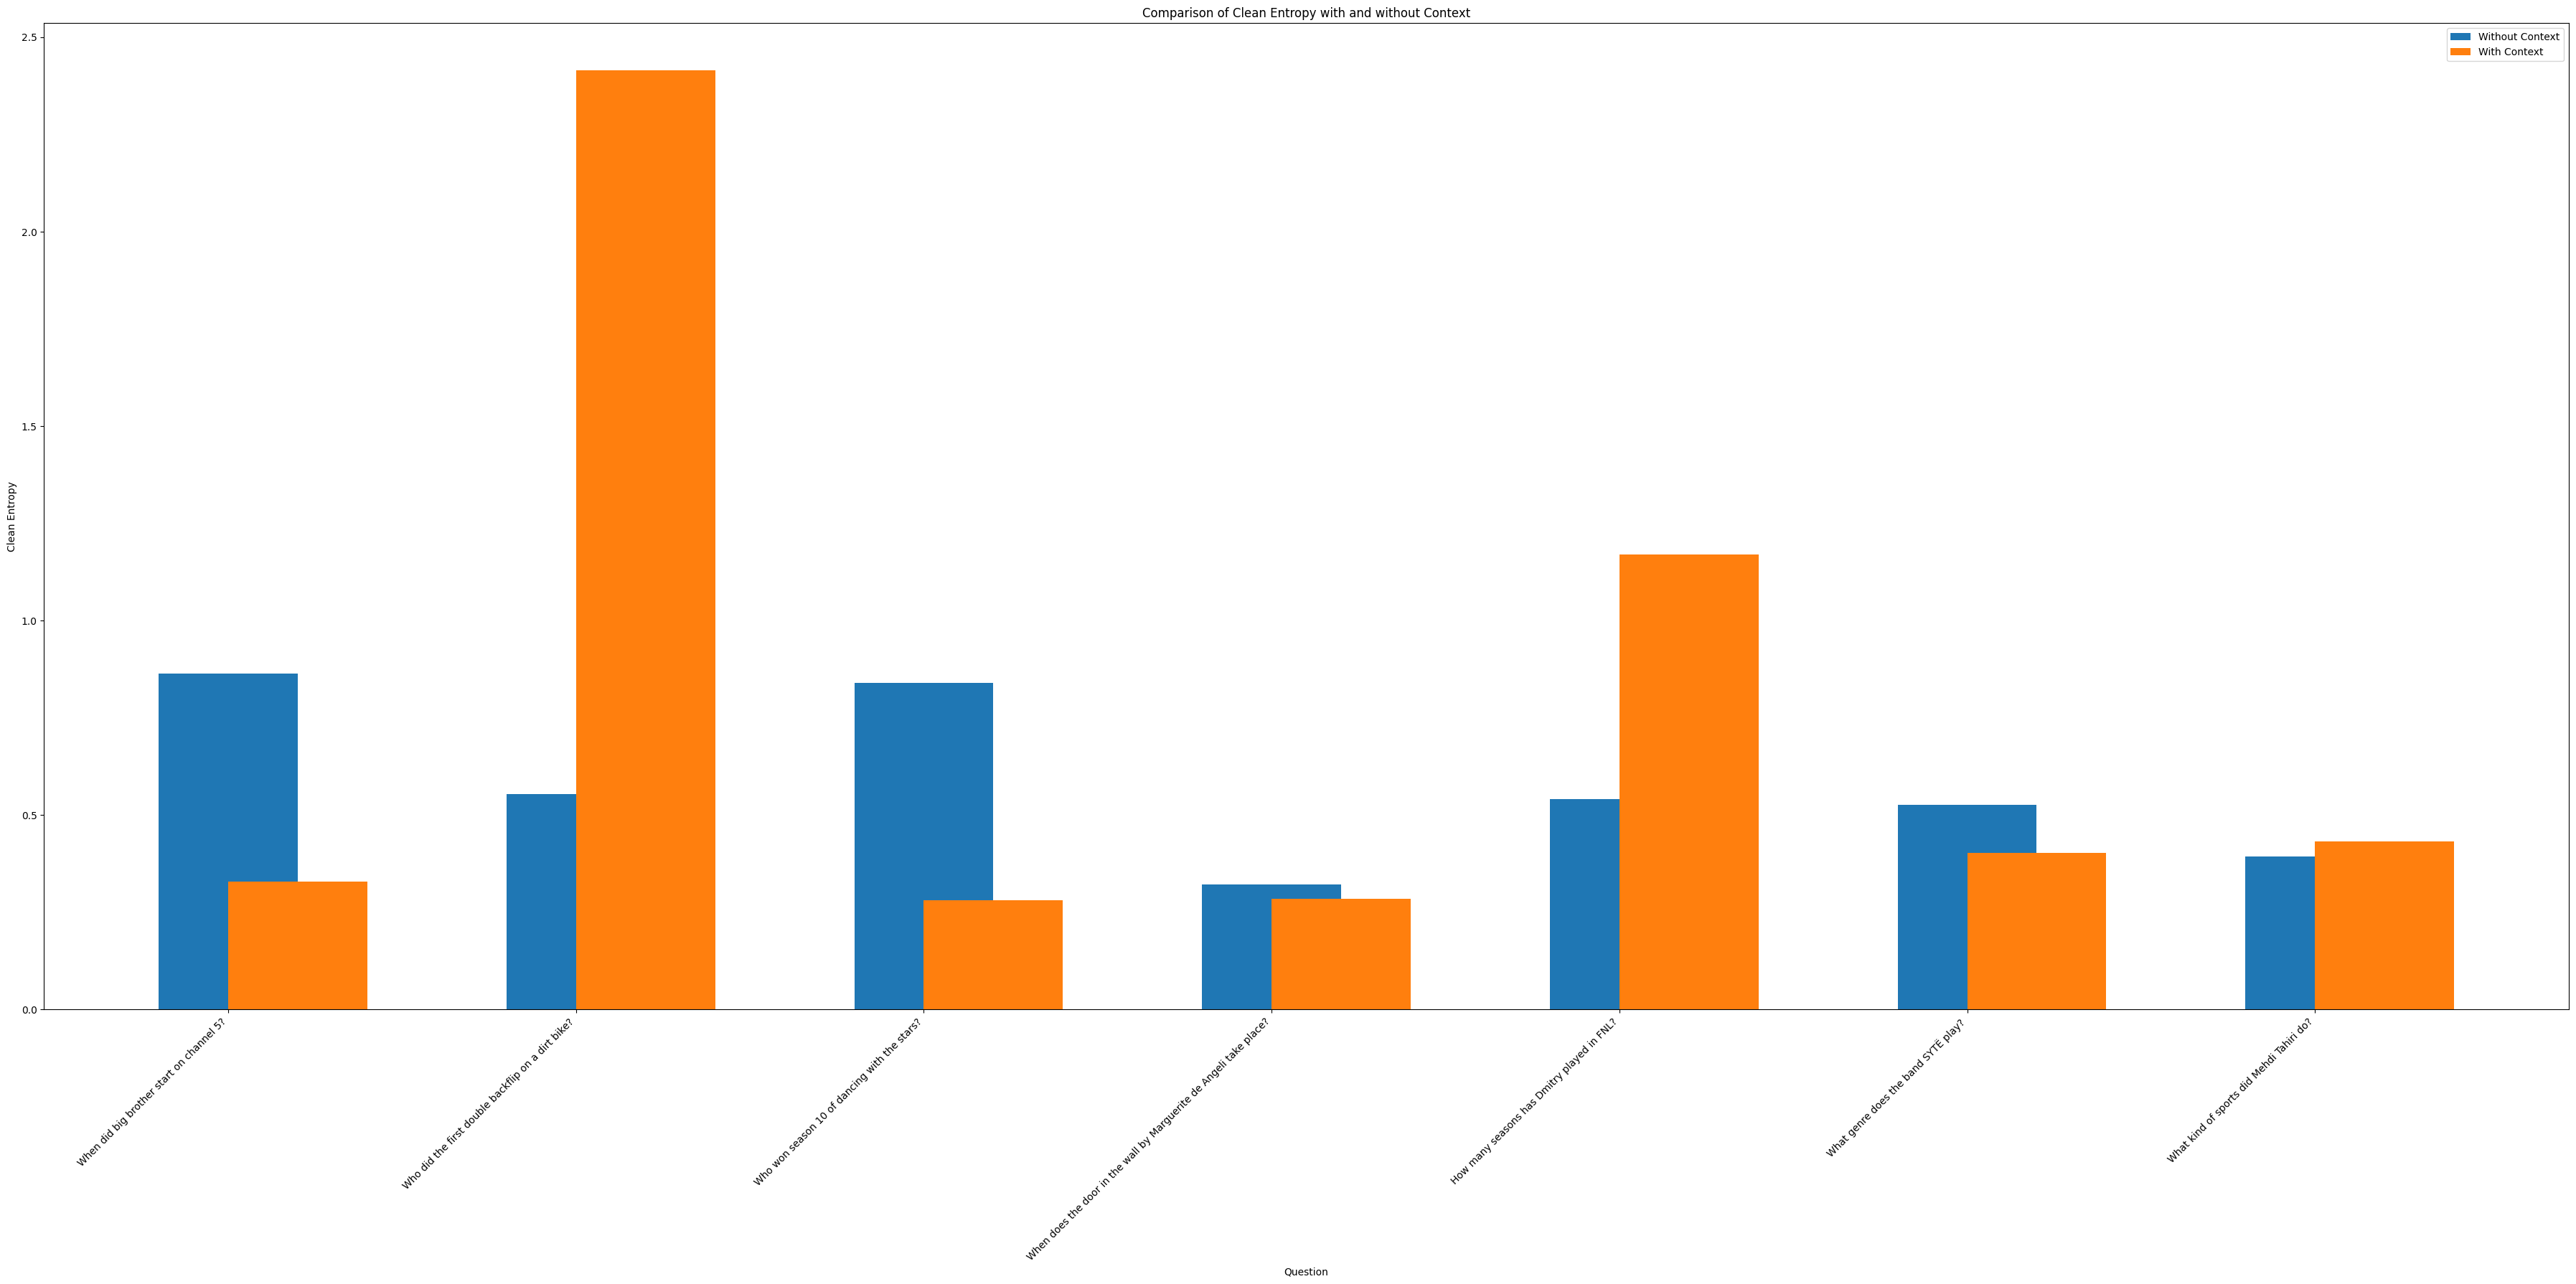

In [26]:
fig, ax = plt.subplots(figsize=(36, 18))

indices = range(len(eval_dataset))

ax.bar(indices, eval_dataset['clean_entropy_without_context'], width=0.4, label='Without Context', align='center')
ax.bar(indices, eval_dataset['clean_entropy_with_context'], width=0.4, label='With Context', align='edge')

ax.set_xlabel("Question")
ax.set_ylabel("Clean Entropy")
ax.set_title("Comparison of Clean Entropy with and without Context")
ax.set_xticks(indices)
ax.set_xticklabels(eval_dataset['question'], rotation=45, ha="right")  
ax.legend()

plt.tight_layout()
plt.show()

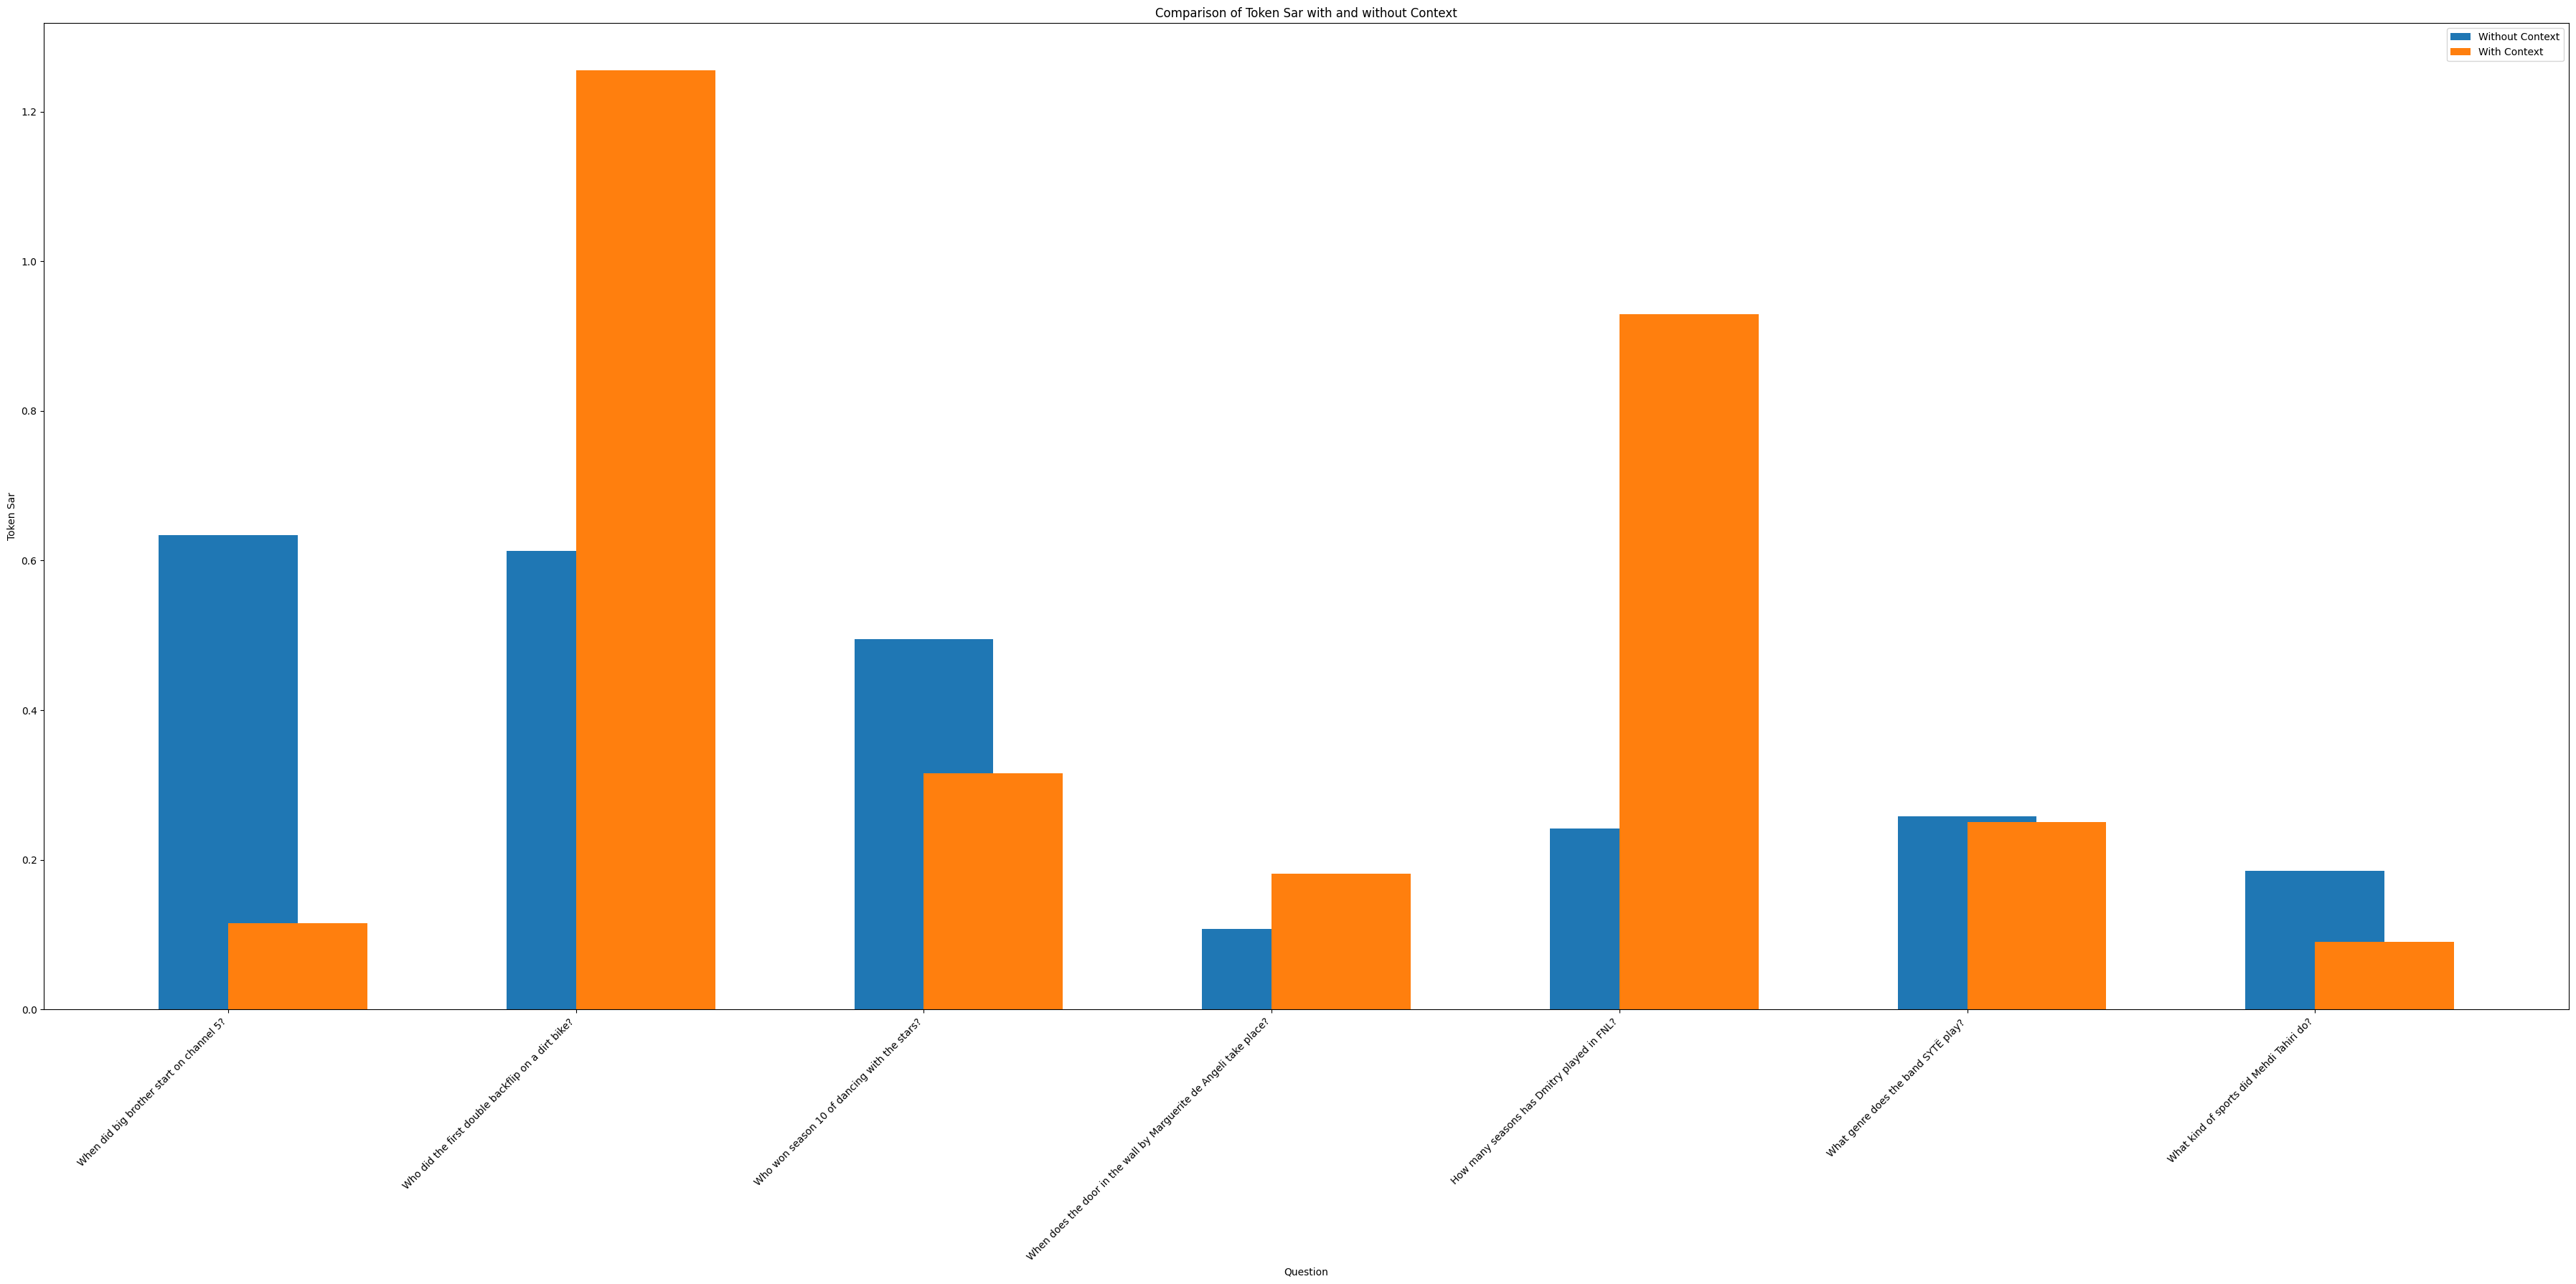

In [27]:
fig, ax = plt.subplots(figsize=(36, 18))

indices = range(len(eval_dataset))

ax.bar(indices, eval_dataset['token_sar_without_context'], width=0.4, label='Without Context', align='center')
ax.bar(indices, eval_dataset['token_sar_with_context'], width=0.4, label='With Context', align='edge')

ax.set_xlabel("Question")
ax.set_ylabel("Token Sar")
ax.set_title("Comparison of Token Sar with and without Context")
ax.set_xticks(indices)
ax.set_xticklabels(eval_dataset['question'], rotation=45, ha="right")  
ax.legend()

plt.tight_layout()
plt.show()

## Full dataset

In [51]:
from datasets import load_dataset

nq_dataset = load_dataset('cjlovering/natural-questions-short')['train'].shuffle(seed=42).select(range(1000)).to_pandas()
nq_dataset = nq_dataset[['contexts', 'questions', 'answers']]
nq_dataset['questions'] = nq_dataset['questions'].apply(lambda x: x[0]['input_text'])
nq_dataset['answers'] = nq_dataset['answers'].apply(lambda x: x[0]['span_text'])
nq_dataset = nq_dataset.rename(columns={'questions': 'question', 'answers': 'golden_answer', 'contexts': 'context'})

In [ ]:
nq_dataset

In [ ]:
for index, row in tqdm(nq_dataset.iterrows()):
    question = row['question']
    context = row['context']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    # clean_entropy without context
    result = estimate_uncertainty(
        model,
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=True
    )
    answer_without_context, clean_entropy_without_context = result.generation_text, result.uncertainty

    # clean_entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=True
    )
    answer_with_context, clean_entropy_with_context = result.generation_text, result.uncertainty

    # token_sar without context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, token_sar_without_context = result.generation_text, result.uncertainty

    # token_sar with context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, token_sar_with_context = result.generation_text, result.uncertainty

    nq_dataset.loc[index, f'our_answer_without_context'] = answer_without_context
    nq_dataset.loc[index, f'our_answer_with_context'] = answer_with_context

    nq_dataset.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    nq_dataset.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)
    nq_dataset.loc[index, 'clean_entropy_without_context'] = round(clean_entropy_without_context, 4)
    nq_dataset.loc[index, 'clean_entropy_with_context'] = round(clean_entropy_with_context, 4)
    nq_dataset.loc[index, 'token_sar_without_context'] = round(token_sar_without_context, 4)
    nq_dataset.loc[index, 'token_sar_with_context'] = round(token_sar_with_context, 4)
    
nq_dataset.to_csv('data/nq_dataset_with_generated_answers.csv', index=False)

16it [14:45, 47.57s/it]

## Add marked up correctness of generated answer by cotype 16k

In [2]:
nq_dataset = pd.read_csv('data/nq_dataset_with_generated_answers.csv')

In [38]:
system_prompt = """You will be given a user query, a reference answer, and a model's response. Your task is to evaluate the model’s response only in relation to the reference answer. Focus on the accuracy and completeness of the information in the model’s response compared to the reference. Ignore stylistic differences or minor rephrasings

Evaluation criteria:

Score 0 if the model's answer is entirely incorrect or no answer is provided.
Score 0.5 if the model’s answer contains inaccuracies, lacks information, or includes extraneous details not relevant to the query.
Score 1 if the model’s answer is entirely correct and sufficiently answers the query without unnecessary information.
Provide your answer in the format: Score.

Your evaluation will be used to measure consistency and accuracy."""

user_prompt = """Please evaluate the model's response based on its accuracy compared to the reference answer, using one of the following scores:

0: Incorrect or no response
0.5: Partially correct (contains errors, lacks information, or is excessive)
1: Completely correct
Format: Score.

Question: {question} 
Reference Answer: {golden_answer} 
Model Answer: {model_answer}"""

In [ ]:
import os
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

for index, row in tqdm(nq_dataset.iterrows()):
    question = row['question']
    answer_without_context = row['our_answer_without_context']
    answer_with_context = row["our_answer_with_context"]
    golden_answer = row['golden_answer']

    user_prompt_without_context = user_prompt.format(
        question=question, 
        golden_answer=golden_answer, 
        model_answer=answer_without_context
    )

    user_prompt_with_context = user_prompt.format(
        question=question, 
        golden_answer=golden_answer, 
        model_answer=answer_with_context
    )

    chatgpt_is_correct_without_context = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": user_prompt_without_context},
            {"role": "system", "content": system_prompt}
        ]
    ).choices[0].message.content

    chatgpt_is_correct_with_context = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": user_prompt_with_context},
            {"role": "system", "content": system_prompt}
        ]
    ).choices[0].message.content

    nq_dataset.loc[index, 'chatgpt_is_correct_without_context'] = chatgpt_is_correct_without_context
    nq_dataset.loc[index, 'chatgpt_is_correct_with_context'] = chatgpt_is_correct_with_context

In [46]:
nq_dataset.head()

,context,question,golden_answer,our_answer_without_context,our_answer_with_context,entropy_without_context,entropy_with_context,clean_entropy_without_context,clean_entropy_with_context,token_sar_without_context,token_sar_with_context,cotype_is_correct_without_context,cotype_is_correct_with_context,chatgpt_is_correct_without_context,chatgpt_is_correct_with_context
0,The Truman Doctrine was an American foreign po...,what did the u.s. policy called the truman doc...,created to counter Soviet geopolitical expansi...,"The Truman Doctrine, announced by President Ha...",The Truman Doctrine promised to contain Soviet...,0.3936,0.4015,0.3973,0.3337,0.1740,0.1353,1.0,1.0,1.0,1.0
1,The Dark Tower Theatrical release poster Direc...,who wrote the screenplay for the dark tower,Akiva Goldsman Jeff Pinkner Anders Thomas Jens...,"The screenplay for the 2017 film ""The Dark Tow...","Akiva Goldsman, Jeff Pinkner, and Anders Thoma...",0.3243,0.3363,0.2376,0.2832,0.0623,0.1727,1.0,1.0,1.0,0.5
2,This article lists the fifty most - subscribed...,who has the most subscribers in you tube,PewDiePie,As of my cut-off knowledge date (December 2023...,PewDiePie,0.2451,0.1948,0.2715,0.1948,0.1315,0.0115,0.5,1.0,0.5,1.0
3,The San Luis Valley is a region in south - cen...,where is the san luis valley in colorado,south - central Colorado with a small portion ...,The San Luis Valley is located in southern Col...,The San Luis Valley is located in south-centra...,0.3940,0.2693,0.4626,0.1976,0.3080,0.1183,1.0,1.0,0.5,1.0
4,"Gastric acid , gastric juice or stomach acid ,...",what is the acid in the stomach called,"Gastric acid , gastric juice or stomach acid",The acid in the stomach is hydrochloric acid (...,Hydrochloric acid (HCl),0.3071,0.3508,0.2483,0.2741,0.1856,0.1963,1.0,1.0,0.5,0.5


In [57]:
nq_dataset.columns

Index(['context', 'question', 'golden_answer', 'our_answer_without_context',
       'our_answer_with_context', 'entropy_without_context',
       'entropy_with_context', 'clean_entropy_without_context',
       'clean_entropy_with_context', 'token_sar_without_context',
       'token_sar_with_context', 'cotype_is_correct_without_context',
       'cotype_is_correct_with_context', 'chatgpt_is_correct_without_context',
       'chatgpt_is_correct_with_context'],
      dtype='object')

<Axes: ylabel='cotype_is_correct_without_context'>

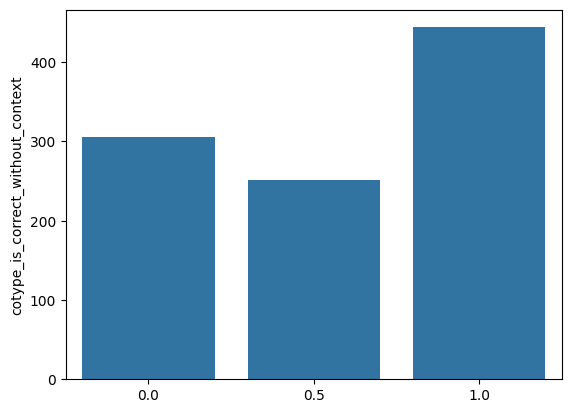

In [49]:
import seaborn as sns
sns.barplot(nq_dataset['cotype_is_correct_without_context'].value_counts())

<Axes: ylabel='cotype_is_correct_with_context'>

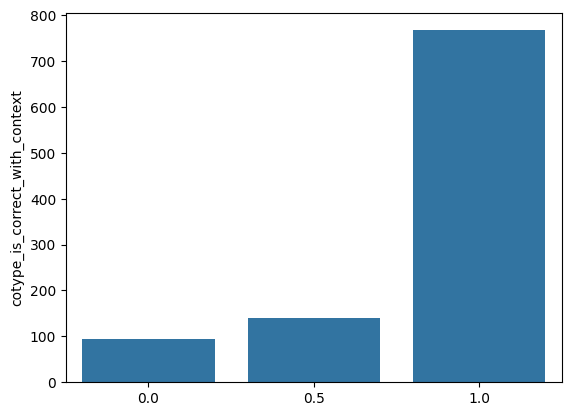

In [50]:
sns.barplot(nq_dataset['cotype_is_correct_with_context'].value_counts())

<Axes: ylabel='chatgpt_is_correct_with_context'>

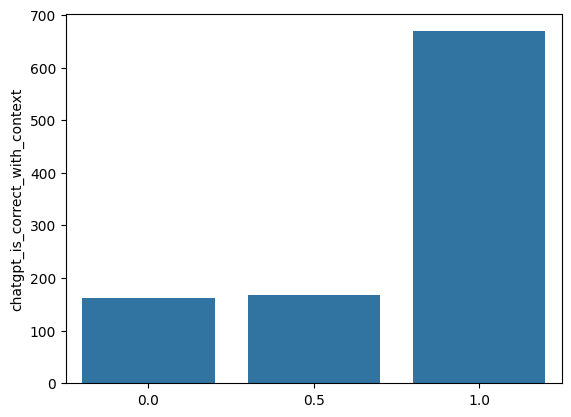

In [55]:
sns.barplot(nq_dataset['chatgpt_is_correct_with_context'].value_counts())

<Axes: ylabel='chatgpt_is_correct_without_context'>

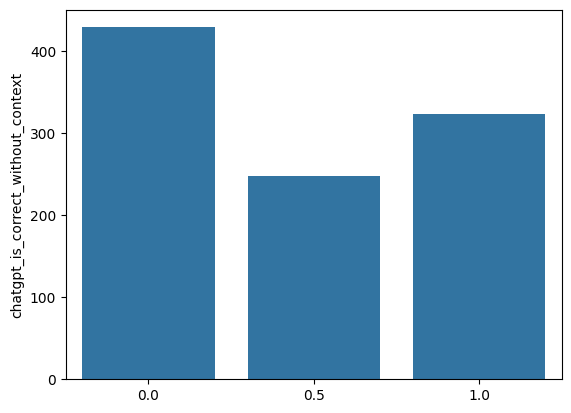

In [56]:
sns.barplot(nq_dataset['chatgpt_is_correct_without_context'].value_counts())

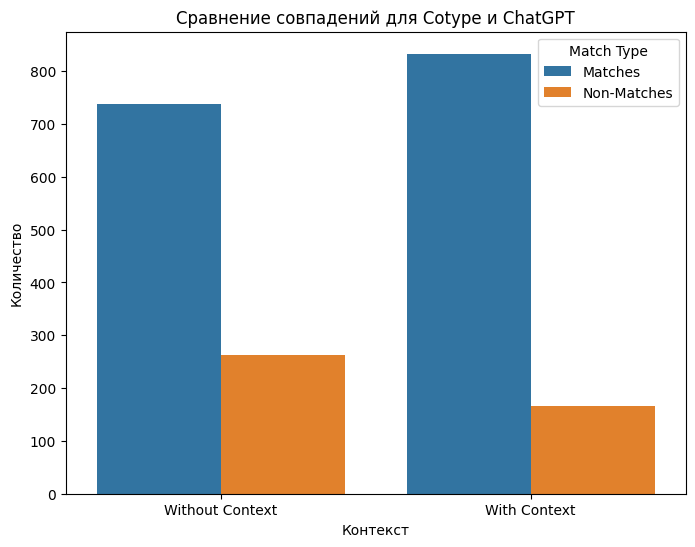

In [58]:
nq_dataset['match_without_context'] = nq_dataset['cotype_is_correct_without_context'] == nq_dataset['chatgpt_is_correct_without_context']
nq_dataset['match_with_context'] = nq_dataset['cotype_is_correct_with_context'] == nq_dataset['chatgpt_is_correct_with_context']

match_counts = pd.DataFrame({
    'Context': ['Without Context', 'With Context'],
    'Matches': [nq_dataset['match_without_context'].sum(), nq_dataset['match_with_context'].sum()],
    'Non-Matches': [len(nq_dataset) - nq_dataset['match_without_context'].sum(), len(nq_dataset) - nq_dataset['match_with_context'].sum()]
})

match_counts_melted = match_counts.melt(id_vars='Context', var_name='Match Type', value_name='Count')

plt.figure(figsize=(8, 6))
sns.barplot(data=match_counts_melted, x='Context', y='Count', hue='Match Type')
plt.title('Сравнение совпадений для Cotype и ChatGPT')
plt.ylabel('Количество')
plt.xlabel('Контекст')
plt.show()

In [3]:
color_map = {1: 'green', 0.5: 'yellow', 0: 'red'}
colors_with_context = nq_dataset['chatgpt_is_correct_with_context'].map(color_map)
colors_without_context = nq_dataset['chatgpt_is_correct_without_context'].map(color_map)

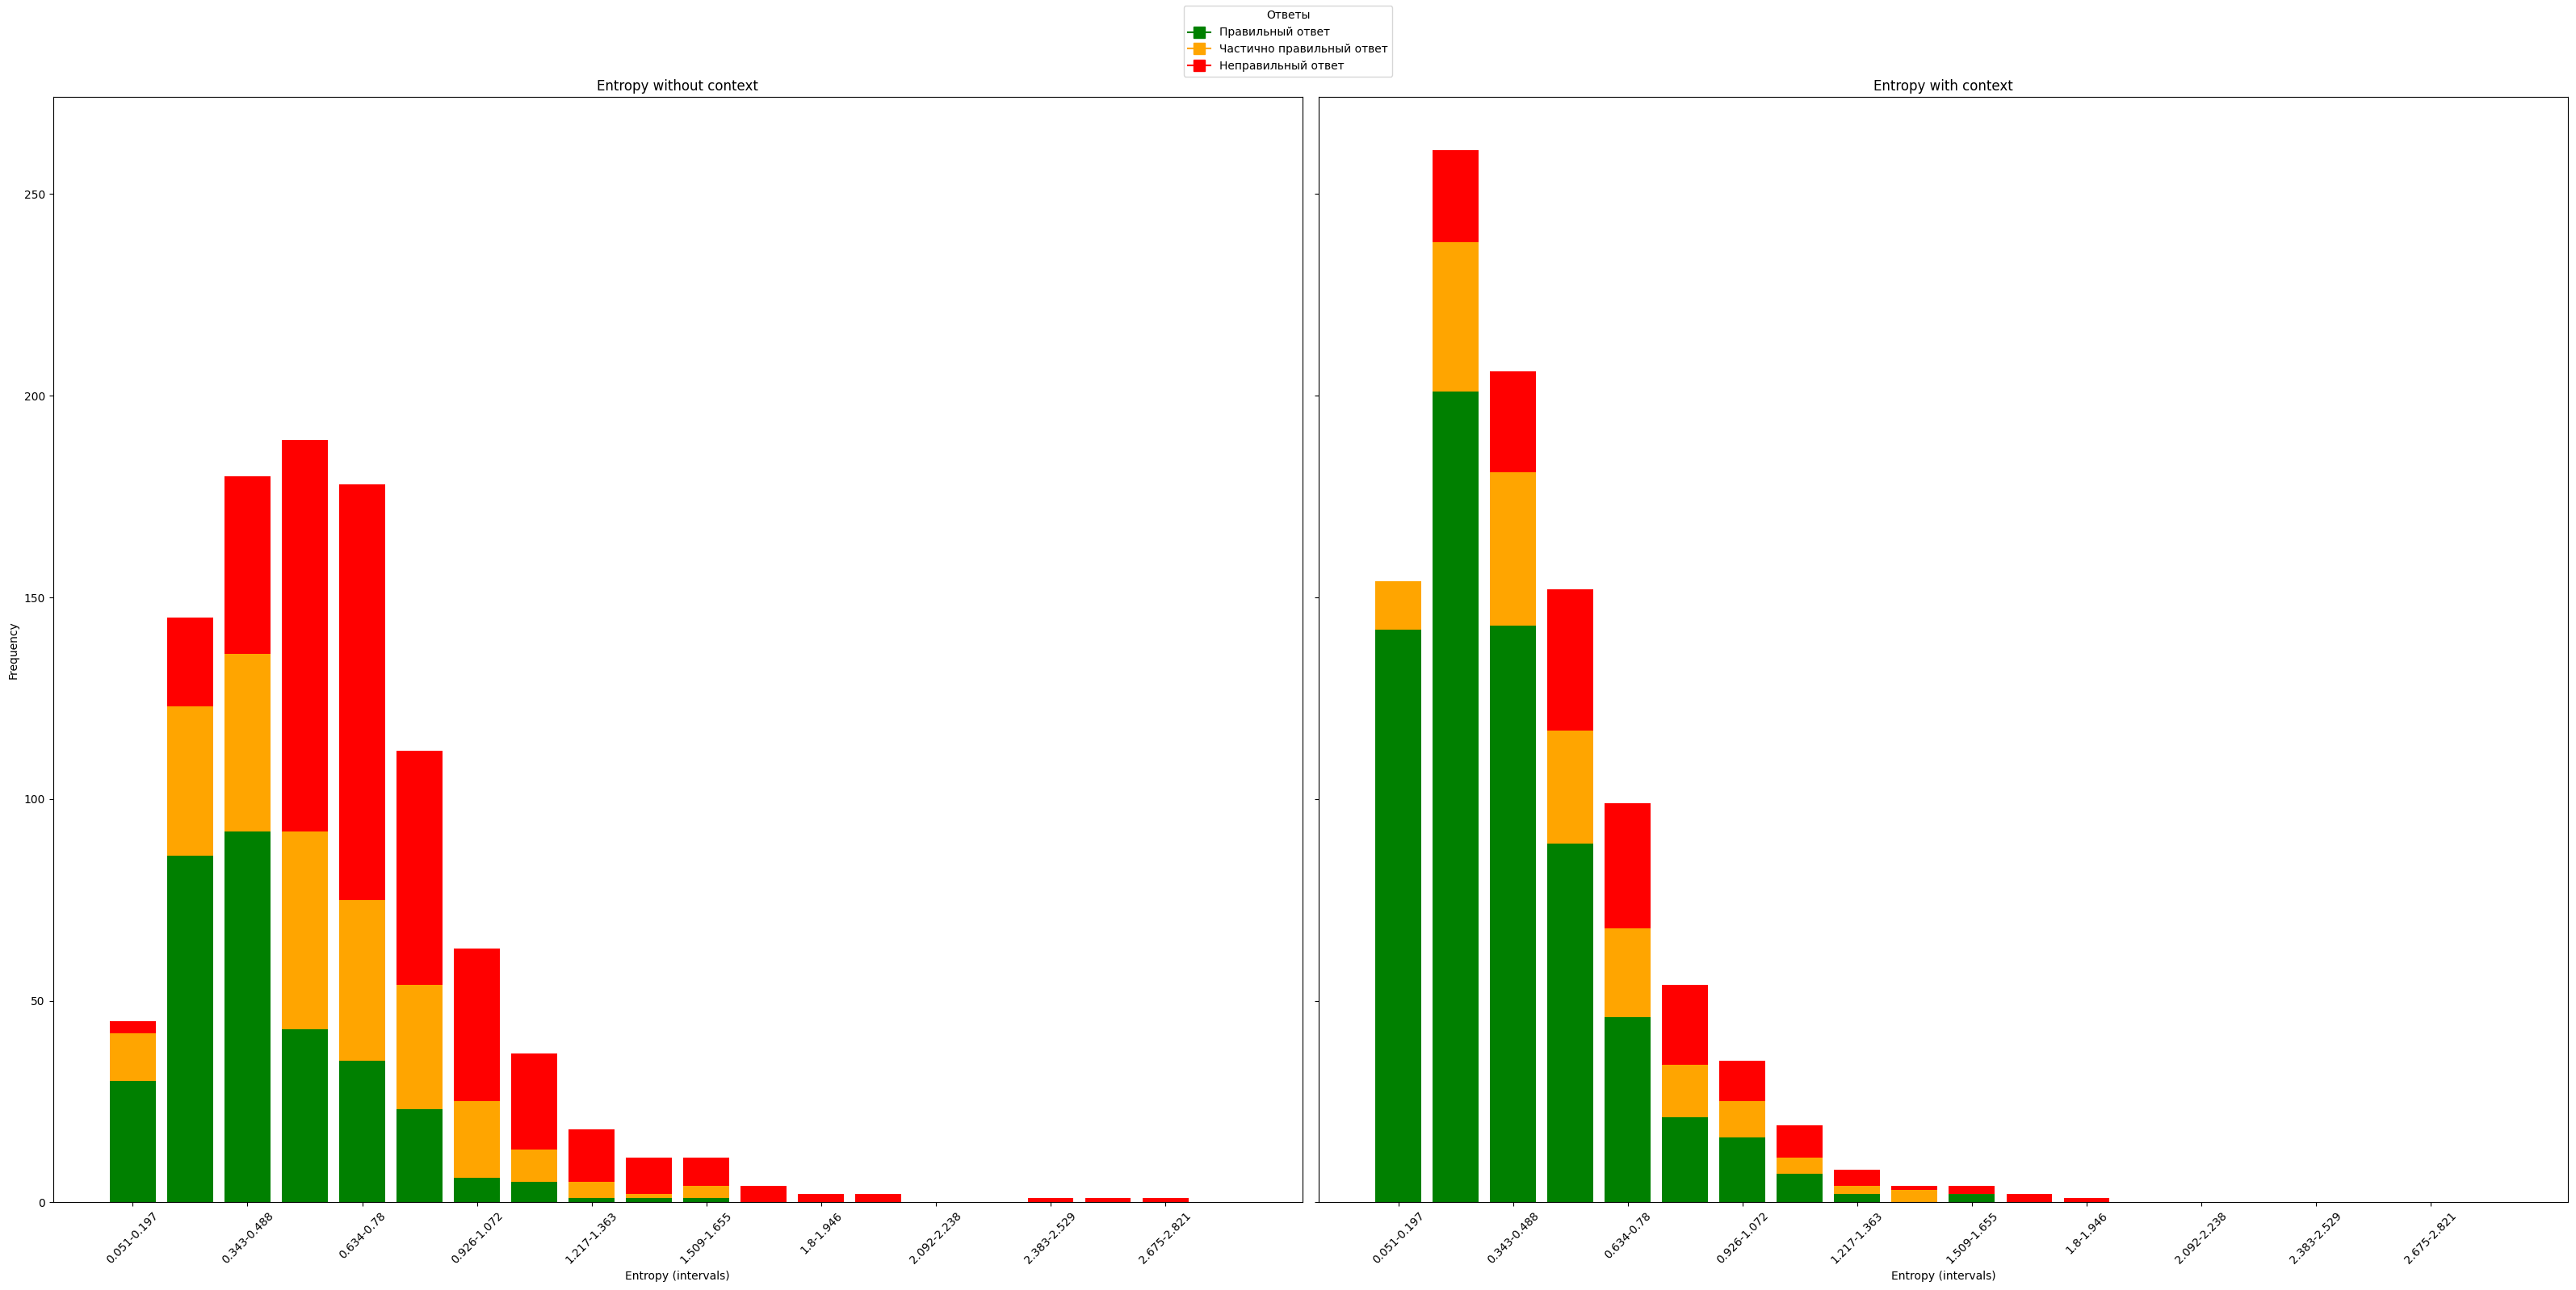

In [20]:
entropy_min = min(nq_dataset['entropy_without_context'].min(), nq_dataset['entropy_with_context'].min())
entropy_max = max(nq_dataset['entropy_without_context'].max(), nq_dataset['entropy_with_context'].max())
bin_edges = np.linspace(entropy_min, entropy_max, num_bins + 1)

binned_data_without_context = pd.DataFrame({
    'bin_left': bin_edges[:-1],
    'bin_right': bin_edges[1:],
    'correct': 0,
    'partially_correct': 0,
    'incorrect': 0
})

binned_data_with_context = binned_data_without_context.copy()

for i in range(num_bins):
    bin_mask = (nq_dataset['entropy_without_context'] >= bin_edges[i]) & (nq_dataset['entropy_without_context'] < bin_edges[i + 1])
    binned_data_without_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 1).values)
    binned_data_without_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0.5).values)
    binned_data_without_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0).values)

for i in range(num_bins):
    bin_mask = (nq_dataset['entropy_with_context'] >= bin_edges[i]) & (nq_dataset['entropy_with_context'] < bin_edges[i + 1])
    binned_data_with_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 1).values)
    binned_data_with_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0.5).values)
    binned_data_with_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0).values)

x_labels_without_context = binned_data_without_context['bin_left'].round(3).astype(str) + '-' + binned_data_without_context['bin_right'].round(3).astype(str)
x_labels_with_context = binned_data_with_context['bin_left'].round(3).astype(str) + '-' + binned_data_with_context['bin_right'].round(3).astype(str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

ax1.bar(x_labels_without_context, binned_data_without_context['correct'], color='green', label='Правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['partially_correct'], bottom=binned_data_without_context['correct'], color='orange', label='Частично правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['incorrect'], bottom=binned_data_without_context['correct'] + binned_data_without_context['partially_correct'], color='red', label='Неправильный ответ')
ax1.set_xlabel('Entropy (intervals)')
ax1.set_ylabel('Frequency')
ax1.set_title('Entropy without context')
ax1.set_xticks(np.arange(0, len(x_labels_without_context), max(1, len(x_labels_without_context) // 10)))
ax1.tick_params(axis='x', rotation=45)

ax2.bar(x_labels_with_context, binned_data_with_context['correct'], color='green', label='Правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['partially_correct'], bottom=binned_data_with_context['correct'], color='orange', label='Частично правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['incorrect'], bottom=binned_data_with_context['correct'] + binned_data_with_context['partially_correct'], color='red', label='Неправильный ответ')
ax2.set_xlabel('Entropy (intervals)')
ax2.set_title('Entropy with context')
ax2.set_xticks(np.arange(0, len(x_labels_with_context), max(1, len(x_labels_with_context) // 10)))
ax2.tick_params(axis='x', rotation=45)

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [
    plt.Line2D([0], [0], marker='s', color='green', markersize=10, label='Правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='orange', markersize=10, label='Частично правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='red', markersize=10, label='Неправильный ответ')
]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

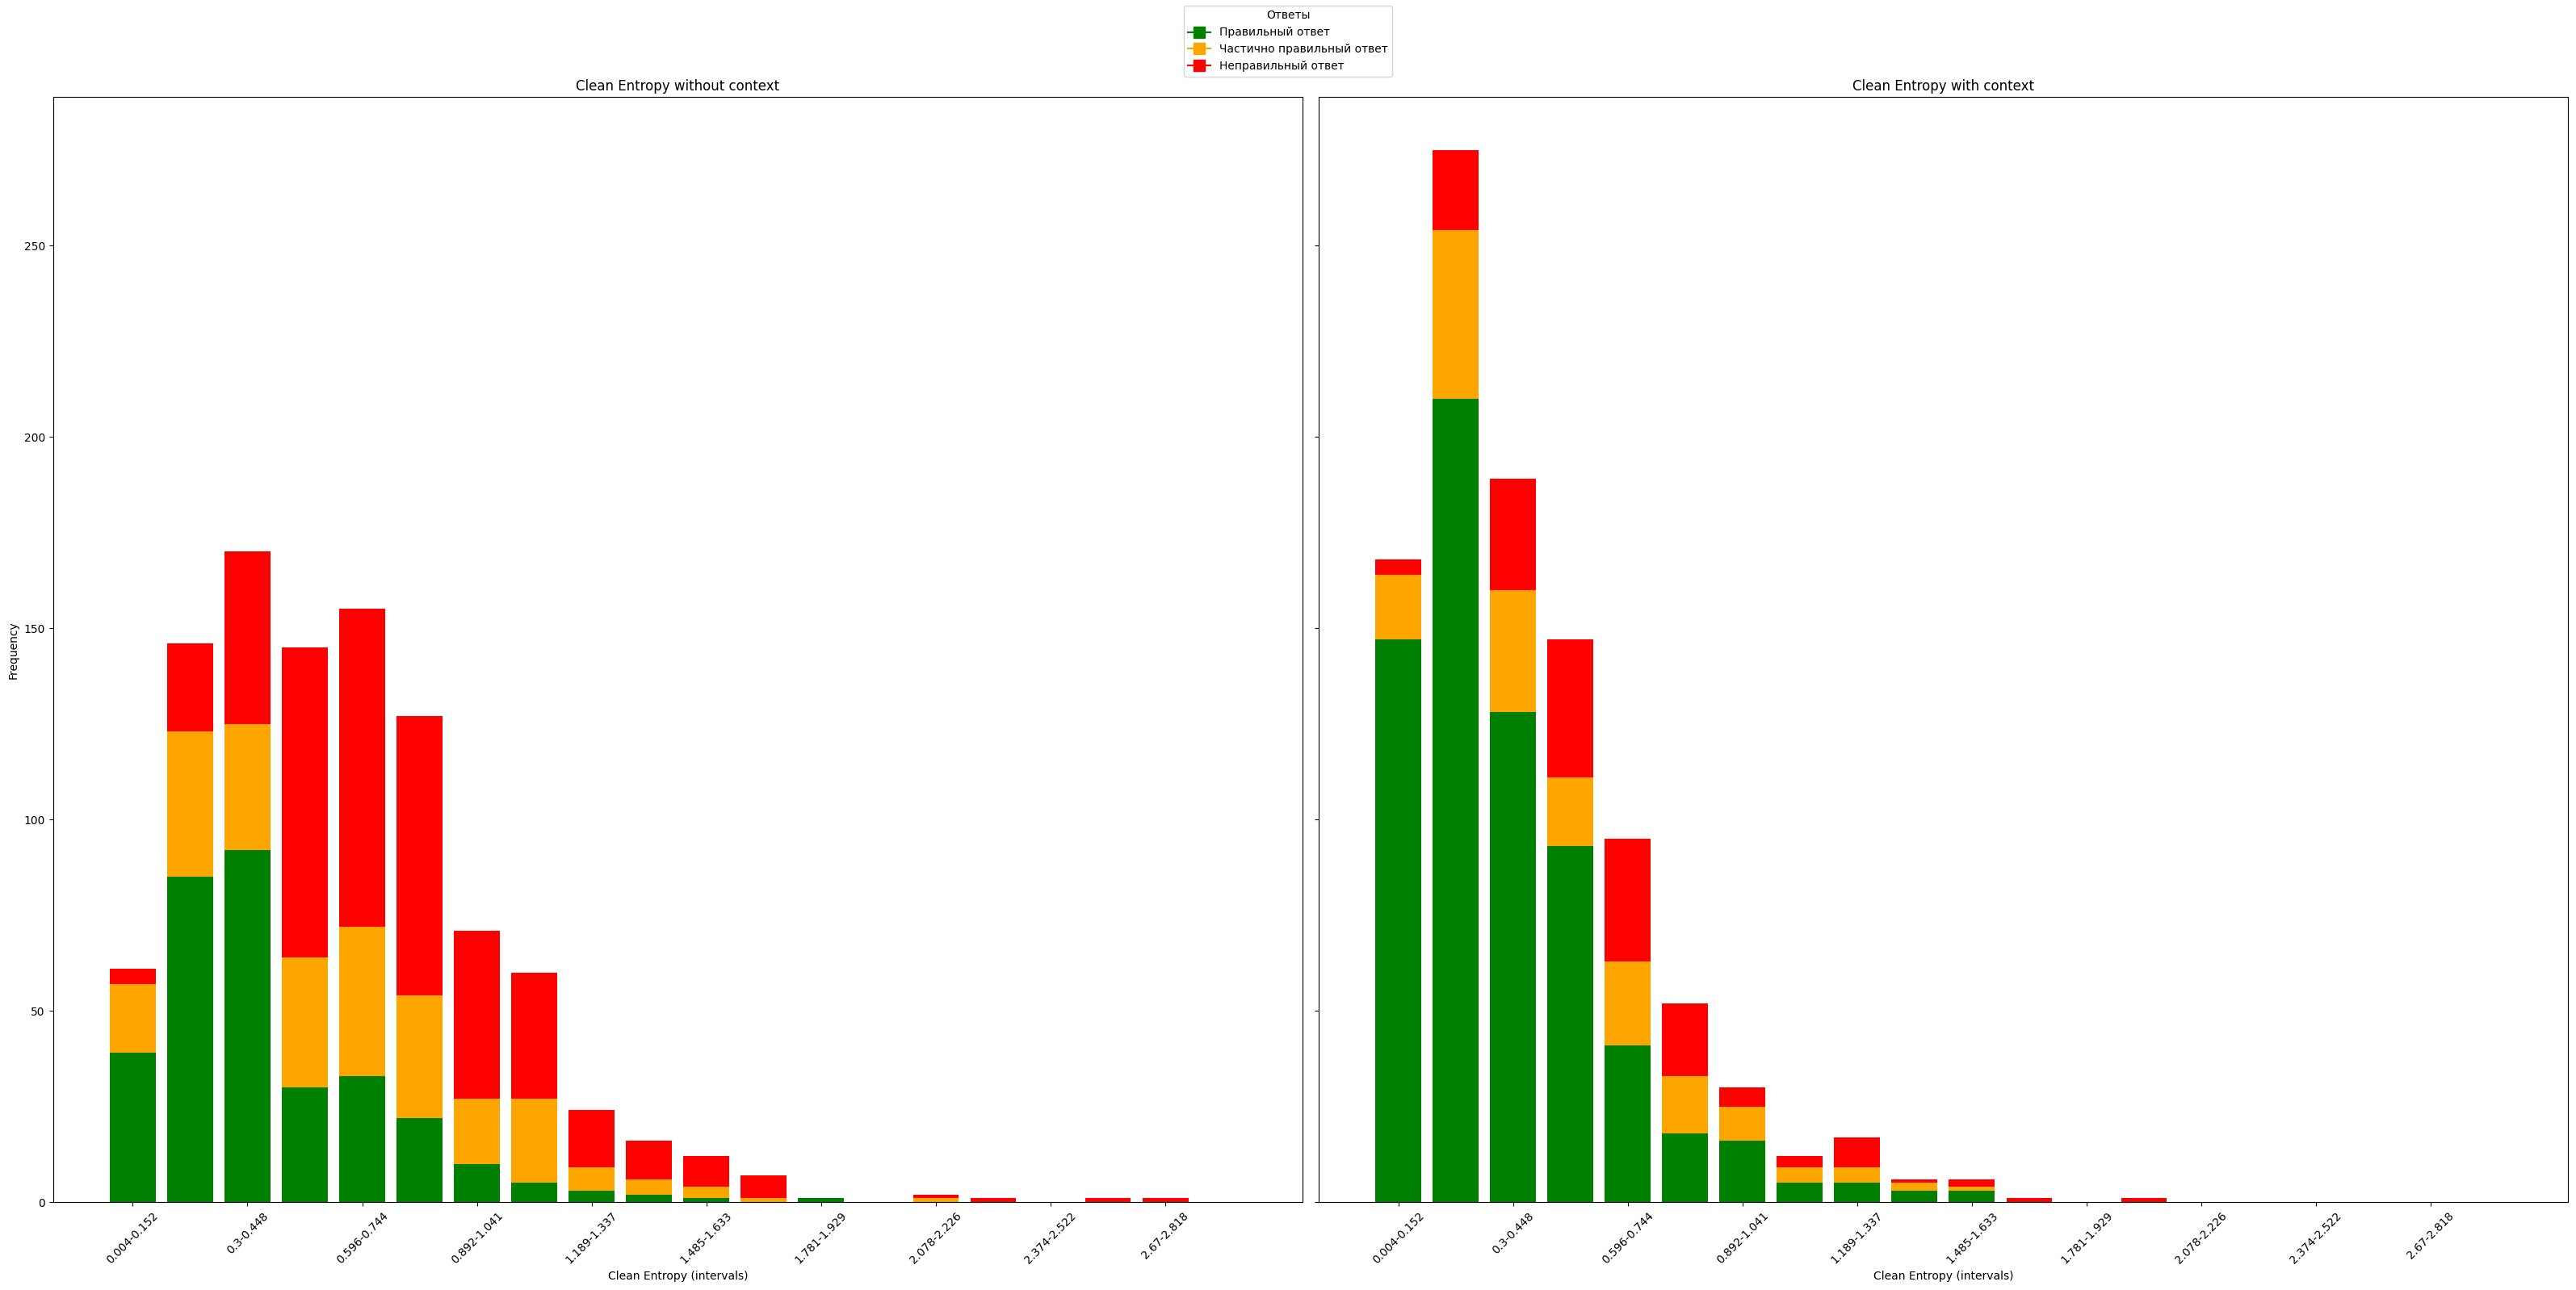

In [22]:
clean_entropy_min = min(nq_dataset['clean_entropy_without_context'].min(), nq_dataset['clean_entropy_with_context'].min())
clean_entropy_max = max(nq_dataset['clean_entropy_without_context'].max(), nq_dataset['clean_entropy_with_context'].max())
bin_edges = np.linspace(clean_entropy_min, clean_entropy_max, num_bins + 1)

binned_data_without_context = pd.DataFrame({
    'bin_left': bin_edges[:-1],
    'bin_right': bin_edges[1:],
    'correct': 0,
    'partially_correct': 0,
    'incorrect': 0
})

binned_data_with_context = binned_data_without_context.copy()

for i in range(num_bins):
    bin_mask = (nq_dataset['clean_entropy_without_context'] >= bin_edges[i]) & (nq_dataset['clean_entropy_without_context'] < bin_edges[i + 1])
    binned_data_without_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 1).values)
    binned_data_without_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0.5).values)
    binned_data_without_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0).values)

for i in range(num_bins):
    bin_mask = (nq_dataset['clean_entropy_with_context'] >= bin_edges[i]) & (nq_dataset['clean_entropy_with_context'] < bin_edges[i + 1])
    binned_data_with_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 1).values)
    binned_data_with_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0.5).values)
    binned_data_with_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0).values)

x_labels_without_context = binned_data_without_context['bin_left'].round(3).astype(str) + '-' + binned_data_without_context['bin_right'].round(3).astype(str)
x_labels_with_context = binned_data_with_context['bin_left'].round(3).astype(str) + '-' + binned_data_with_context['bin_right'].round(3).astype(str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

ax1.bar(x_labels_without_context, binned_data_without_context['correct'], color='green', label='Правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['partially_correct'], bottom=binned_data_without_context['correct'], color='orange', label='Частично правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['incorrect'], bottom=binned_data_without_context['correct'] + binned_data_without_context['partially_correct'], color='red', label='Неправильный ответ')
ax1.set_xlabel('Clean Entropy (intervals)')
ax1.set_ylabel('Frequency')
ax1.set_title('Clean Entropy without context')
ax1.set_xticks(np.arange(0, len(x_labels_without_context), max(1, len(x_labels_without_context) // 10)))
ax1.tick_params(axis='x', rotation=45)

ax2.bar(x_labels_with_context, binned_data_with_context['correct'], color='green', label='Правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['partially_correct'], bottom=binned_data_with_context['correct'], color='orange', label='Частично правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['incorrect'], bottom=binned_data_with_context['correct'] + binned_data_with_context['partially_correct'], color='red', label='Неправильный ответ')
ax2.set_xlabel('Clean Entropy (intervals)')
ax2.set_title('Clean Entropy with context')
ax2.set_xticks(np.arange(0, len(x_labels_with_context), max(1, len(x_labels_with_context) // 10)))
ax2.tick_params(axis='x', rotation=45)

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [
    plt.Line2D([0], [0], marker='s', color='green', markersize=10, label='Правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='orange', markersize=10, label='Частично правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='red', markersize=10, label='Неправильный ответ')
]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [23]:
nq_dataset.columns

Index(['context', 'question', 'golden_answer', 'our_answer_without_context',
       'our_answer_with_context', 'entropy_without_context',
       'entropy_with_context', 'clean_entropy_without_context',
       'clean_entropy_with_context', 'token_sar_without_context',
       'token_sar_with_context', 'cotype_is_correct_without_context',
       'cotype_is_correct_with_context', 'chatgpt_is_correct_without_context',
       'chatgpt_is_correct_with_context'],
      dtype='object')

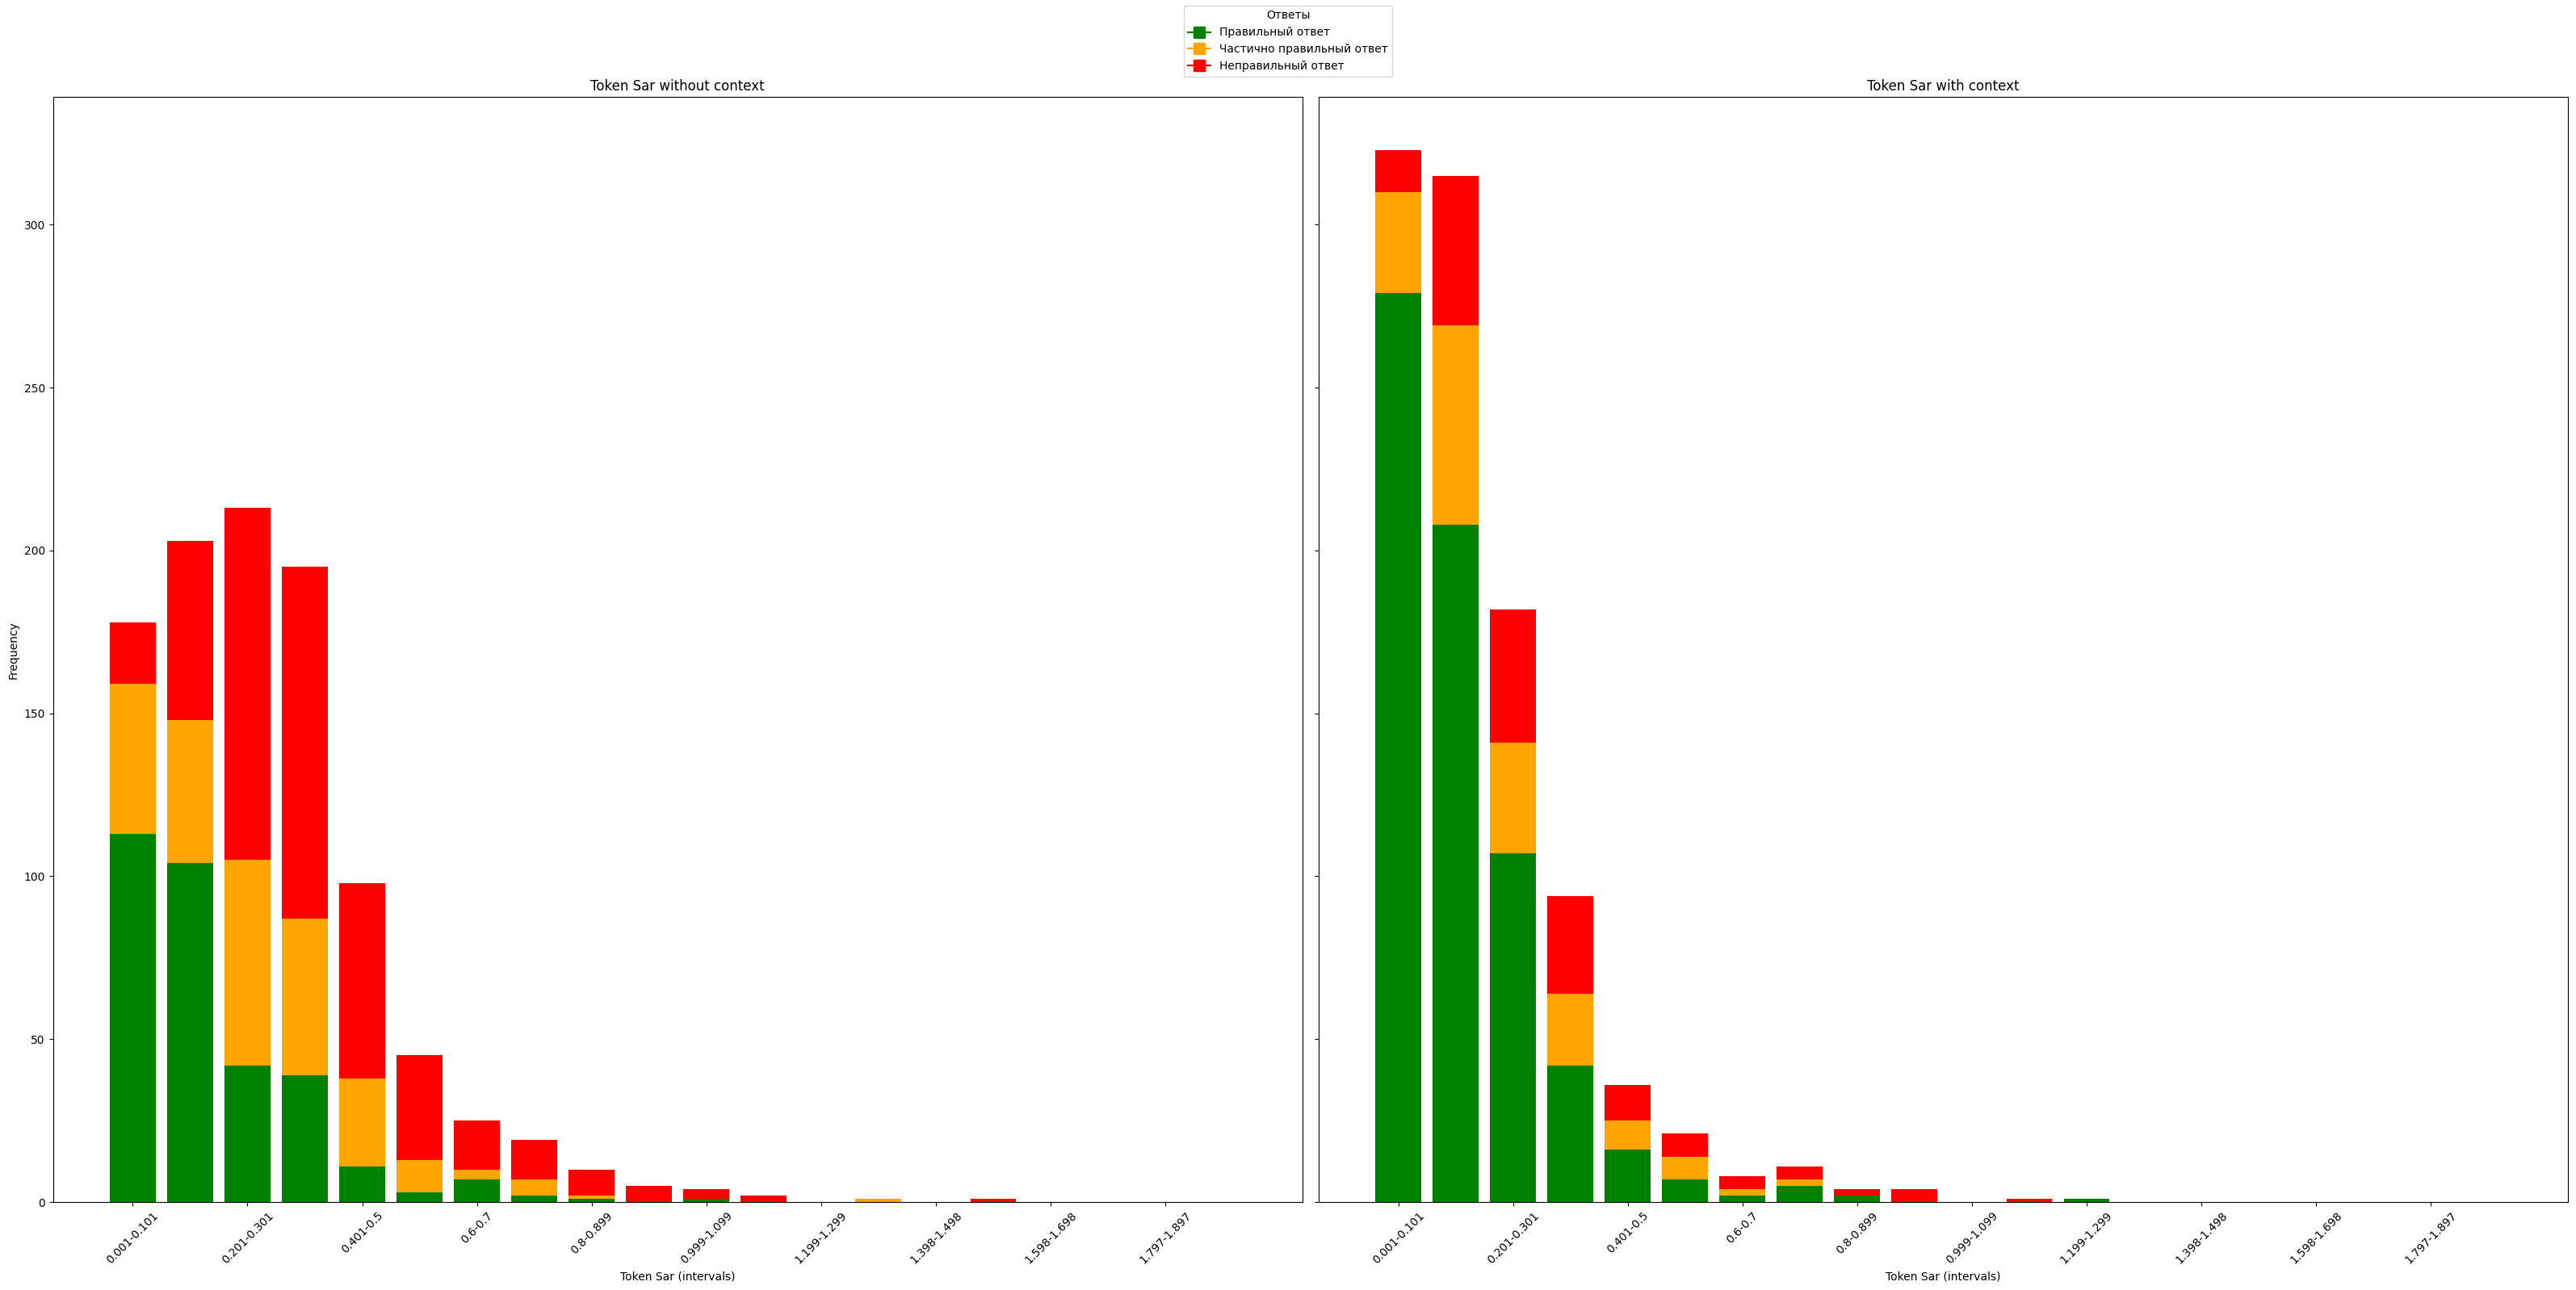

In [24]:
token_sar_min = min(nq_dataset['token_sar_without_context'].min(), nq_dataset['token_sar_with_context'].min())
token_sar_max = max(nq_dataset['token_sar_without_context'].max(), nq_dataset['token_sar_with_context'].max())
bin_edges = np.linspace(token_sar_min, token_sar_max, num_bins + 1)

binned_data_without_context = pd.DataFrame({
    'bin_left': bin_edges[:-1],
    'bin_right': bin_edges[1:],
    'correct': 0,
    'partially_correct': 0,
    'incorrect': 0
})

binned_data_with_context = binned_data_without_context.copy()

for i in range(num_bins):
    bin_mask = (nq_dataset['token_sar_without_context'] >= bin_edges[i]) & (nq_dataset['token_sar_without_context'] < bin_edges[i + 1])
    binned_data_without_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 1).values)
    binned_data_without_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0.5).values)
    binned_data_without_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0).values)

for i in range(num_bins):
    bin_mask = (nq_dataset['token_sar_with_context'] >= bin_edges[i]) & (nq_dataset['token_sar_with_context'] < bin_edges[i + 1])
    binned_data_with_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 1).values)
    binned_data_with_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0.5).values)
    binned_data_with_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0).values)

x_labels_without_context = binned_data_without_context['bin_left'].round(3).astype(str) + '-' + binned_data_without_context['bin_right'].round(3).astype(str)
x_labels_with_context = binned_data_with_context['bin_left'].round(3).astype(str) + '-' + binned_data_with_context['bin_right'].round(3).astype(str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

ax1.bar(x_labels_without_context, binned_data_without_context['correct'], color='green', label='Правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['partially_correct'], bottom=binned_data_without_context['correct'], color='orange', label='Частично правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['incorrect'], bottom=binned_data_without_context['correct'] + binned_data_without_context['partially_correct'], color='red', label='Неправильный ответ')
ax1.set_xlabel('Token Sar (intervals)')
ax1.set_ylabel('Frequency')
ax1.set_title('Token Sar without context')
ax1.set_xticks(np.arange(0, len(x_labels_without_context), max(1, len(x_labels_without_context) // 10)))
ax1.tick_params(axis='x', rotation=45)

ax2.bar(x_labels_with_context, binned_data_with_context['correct'], color='green', label='Правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['partially_correct'], bottom=binned_data_with_context['correct'], color='orange', label='Частично правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['incorrect'], bottom=binned_data_with_context['correct'] + binned_data_with_context['partially_correct'], color='red', label='Неправильный ответ')
ax2.set_xlabel('Token Sar (intervals)')
ax2.set_title('Token Sar with context')
ax2.set_xticks(np.arange(0, len(x_labels_with_context), max(1, len(x_labels_with_context) // 10)))
ax2.tick_params(axis='x', rotation=45)

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [
    plt.Line2D([0], [0], marker='s', color='green', markersize=10, label='Правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='orange', markersize=10, label='Частично правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='red', markersize=10, label='Неправильный ответ')
]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Add marked up is_lack_of_info by ChatGPT

In [ ]:
system_prompt = "As a response evaluator, output 1 when the model’s response indicates uncertainty, lacks information, or states an inability to provide information (e.g., ‘I don’t know,’ ‘I’m not sure,’ or ‘I cannot provide any information on this topic’). Output 0 if the model’s response contains relevant information, explanations, or attempts to provide a clear and informative answer to the prompt."

for index, row in tqdm(nq_dataset.iterrows()):
    answer_without_context = row['our_answer_without_context']
    answer_with_context = row["our_answer_with_context"]

    is_lack_of_info_without_context = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": answer_without_context},
            {"role": "system", "content": system_prompt}
        ]
    ).choices[0].message.content

    is_lack_of_info_with_context = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": answer_with_context},
            {"role": "system", "content": system_prompt}
        ]
    ).choices[0].message.content

    nq_dataset.loc[index, f'is_lack_of_info_without_context'] = is_lack_of_info_without_context
    nq_dataset.loc[index, f'is_lack_of_info_with_context'] = is_lack_of_info_with_context
